# Machine Learning para Predições em Saúde
Desenvolvido no Curso de Verão - 2025

Faculdade de Saúde Pública - USP

## Visão Geral do Projeto
Este projeto demonstra a aplicação de algoritmos de machine learning para predição de risco cardiovascular utilizando dados de saúde. Comparamos o desempenho de diversos algoritmos, incluindo o recente TabPFN (Tabular Prior-Data Fitted Networks), uma abordagem baseada em transformers para dados tabulares.

## Etapas de Análise
1. **Instalação de bibliotecas necessárias**: Configuração do ambiente com os pacotes essenciais para análise de dados e machine learning.

2. **Importação de bibliotecas**: Carregamento das dependências para manipulação de dados, visualização e implementação de modelos preditivos.

3. **Obtenção do conjunto de dados**: Aquisição dos dados de saúde para análise e modelagem.

4. **Pré-processamento dos dados**: Limpeza, transformação e preparação dos dados para modelagem.

5. **Execução de algoritmos de machine learning**: Implementação e avaliação de diversos modelos preditivos.

6. **Desenvolvimento de pipeline personalizada**: Abordagem alternativa à estrutura automatizada.

7. **Seleção de variáveis com BORUTA**: Identificação das características mais relevantes para o modelo.

8. **Implementação do CatBoost com BORUTA**: Aplicação do algoritmo CatBoost com as variáveis selecionadas.

9. **Análise dos valores de Shapley**: Interpretação dos resultados do modelo para entender a contribuição de cada variável.

10. **Persistência do modelo**: Salvamento e carregamento do modelo treinado para uso futuro.

11. **Integração do TABPFN**: Avaliação do desempenho do modelo TabPFN em comparação com outros algoritmos.

---

## **1. Instalação de Bibliotecas Necessárias**

Nesta seção, instalaremos os pacotes essenciais para nossa análise. Cada biblioteca tem um propósito específico:

- **dfply**: Implementa operações de manipulação de dados inspiradas na sintaxe do R/dplyr.
- **scikit-plot**: Fornece visualizações específicas para machine learning.
- **graphviz**: Possibilita a criação de visualizações de grafos (útil para árvores de decisão).
- **dtreeviz**: Permite visualizações detalhadas de árvores de decisão.
- **catboost**: Algoritmo de gradient boosting otimizado para variáveis categóricas.
- **boruta**: Implementa o algoritmo de seleção de features Boruta.
- **tabpfn**: Implementa o modelo TabPFN (Tabular Prior-Data Fitted Networks).

In [1]:
# Instalação das bibliotecas necessárias para análise de dados e machine learning
!pip install dfply
!pip install scikit-plot
!pip install graphviz
!pip install dtreeviz
!pip install catboost
!pip install boruta
!pip install tabpfn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## 2. Importação de Bibliotecas e Pacotes

Nesta seção, importamos as bibliotecas que serão utilizadas ao longo do projeto. Cada biblioteca tem uma função específica:

- **pandas/numpy**: Fundamentais para manipulação e processamento de dados estruturados.
- **matplotlib/seaborn**: Ferramentas para visualização de dados.
- **scikit-learn**: Principal biblioteca para implementação de algoritmos de machine learning.
- **xgboost/lightgbm/catboost**: Implementações eficientes de algoritmos baseados em gradient boosting.
- **dfply**: Para operações de manipulação de dataframes com sintaxe inspirada em dplyr.
- **dtreeviz**: Para visualização avançada de árvores de decisão.
- **tabpfn**: Modelo baseado em transformers para dados tabulares.

In [2]:
# Bibliotecas fundamentais para processamento de dados
import pandas as pd  # Manipulação de dados tabulares
import numpy as np  # Computação numérica eficiente
import matplotlib.pyplot as plt  # Visualizações básicas
import seaborn as sns  # Visualizações estatísticas avançadas

# Configuração de visualizações no notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format = 'retina'

# Configurações adicionais para visualizações
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['DejaVu Sans'], 'size': 10})
rc('mathtext', **{'default': 'regular'})

# Componentes do scikit-learn para modelagem e avaliação
from sklearn.metrics import (roc_curve, auc, confusion_matrix, classification_report,
                            precision_score, recall_score, f1_score, roc_auc_score,
                            accuracy_score, brier_score_loss)
from sklearn.model_selection import (KFold, cross_val_score, train_test_split,
                                    GridSearchCV, RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

# Algoritmos de machine learning
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import preprocessing
from tabpfn import TabPFNClassifier

# Biblioteca para manipulação de dataframes com sintaxe similar ao dplyr
from dfply import *

# Visualização de árvores de decisão
from dtreeviz.trees import *

# Seleção de features e interpretabilidade
from boruta import BorutaPy
import shap

# Persistência de modelos
import joblib
import os

# Supressão de avisos para melhorar a legibilidade da saída
import warnings
warnings.filterwarnings("ignore")

# Definição de semente para reprodutibilidade
np.random.seed(42)

## 3. Obtenção do Conjunto de Dados

Nesta etapa, carregamos o conjunto de dados sobre fatores de risco cardiovascular. Este dataset contém informações de pacientes com diversas variáveis relacionadas à saúde cardiovascular, incluindo:

- Características demográficas (idade, gênero, raça)
- Fatores de risco (hipertensão, diabetes, tabagismo)
- Medidas clínicas (IMC, colesterol, pressão arterial)
- Variável alvo (cvd - presença ou ausência de doença cardiovascular)

Os dados serão carregados diretamente de um repositório online, facilitando a reprodutibilidade da análise.

In [3]:
# Importação do conjunto de dados cardiovasculares de um repositório GitHub
# O dataset contém informações de pacientes e fatores de risco para doença cardiovascular
# Obs: Em arquivos CSV nacionais/latinos, os separadores geralmente são ";" e decimais ","
# Neste caso, utilizamos o padrão internacional (separador "," e decimal ".")

dataset = pd.read_csv('https://raw.githubusercontent.com/laderast/cvdRiskData/master/data-raw/fullPatientData.csv')

### 3.1 Verificação do Conjunto de Dados

Antes de prosseguir com qualquer análise, é fundamental examinar a estrutura e qualidade dos dados importados. Verificaremos:

- Dimensões do dataset (número de observações e variáveis)
- Primeiras linhas para entender o formato e conteúdo dos dados
- Informações sobre os tipos de dados e presença de valores ausentes
- Estatísticas descritivas básicas

Esta etapa inicial de exploração é crucial para identificar possíveis problemas nos dados e planejar adequadamente o pré-processamento.

In [4]:
# Verificação das dimensões do dataset (linhas, colunas)
# Este comando ajuda a identificar rapidamente problemas de importação
# e a entender o volume de dados disponíveis para análise
dataset.shape

(425195, 13)

In [5]:
# Visualização das primeiras linhas do dataset para entender sua estrutura
# O comando .head() mostra por padrão as 5 primeiras linhas
# Para visualizar mais linhas, podemos especificar o número, ex: dataset.head(10)
# Uma alternativa útil é o comando .tail() para ver as últimas linhas dos dados
dataset.head(5)

patientID    age htn treat smoking      race t2d gender  numAge  bmi  \
0  HHUID00076230  20-40   Y     Y       N  Asian/PI   N      M      21   26   
1  HHUID00547835  70-90   N     N       N     White   N      M      86   23   
2  HHUID00450841  20-40   Y     Y       N     White   N      M      29   22   
3  HHUID00380788  20-40   Y     Y       N     White   N      M      24   24   
4  HHUID00043423  20-40   N     N       N  Asian/PI   N      M      40   20   

   tchol  sbp cvd  
0    176  179   N  
1    244  123   N  
2    189  165   N  
3    218  172   N  
4    207  111   N

### **Observações sobre os Dados**

O dataset apresenta 425.195 registros e 13 variáveis, sem valores nulos. Identificamos:

- **Variáveis categóricas** (9): patientID, age, htn, treat, smoking, race, t2d, gender, cvd (alvo)
- **Variáveis numéricas** (4): numAge, bmi, tchol, sbp

Destaca-se que "age" está em formato categórico (faixas etárias) enquanto "numAge" contém a idade numérica exata. É importante verificar valores codificados como missing (ex: "999", "não disponível") que não são automaticamente detectados como nulos pelo pandas.

In [6]:
# Verificação de valores potencialmente codificados como missing
# Procurando valores como "999", "000", "não disponível", etc. nas colunas categóricas

# Verificando colunas categóricas
categorical_cols = dataset.select_dtypes(include=['object']).columns
print("Verificando valores únicos em colunas categóricas:")
for col in categorical_cols:
    unique_vals = dataset[col].unique()
    if len(unique_vals) < 10:  # Exibir apenas se tiver poucos valores únicos
        print(f"{col}: {sorted(unique_vals)}")
    else:
        print(f"{col}: {len(unique_vals)} valores únicos")

# Verificando valores extremos em colunas numéricas que podem indicar missing
numeric_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
print("\nVerificando valores extremos em colunas numéricas:")
for col in numeric_cols:
    min_val = dataset[col].min()
    max_val = dataset[col].max()
    print(f"{col}: Min={min_val}, Max={max_val}")
    
    # Verificando se existem valores suspeitos (ex: 999, 9999, -1)
    suspicious = [999, 9999, -1, -99]
    for val in suspicious:
        count = (dataset[col] == val).sum()
        if count > 0:
            print(f"  ⚠️ Encontrados {count} registros com valor {val}")

Verificando valores únicos em colunas categóricas:
patientID: 425195 valores únicos
age: ['0-20', '20-40', '40-55', '55-70', '70-90']
htn: ['N', 'Y']
treat: ['N', 'Y']
smoking: ['N', 'Y']
race: ['AmInd', 'Asian/PI', 'Black/AfAm', 'White']
t2d: ['N', 'Y']
gender: ['F', 'M']
cvd: ['N', 'Y']

Verificando valores extremos em colunas numéricas:
numAge: Min=0, Max=90
bmi: Min=15, Max=36
tchol: Min=155, Max=245
sbp: Min=73, Max=222


### Verificação de Valores Codificados como Missing

A análise não identificou valores codificados como missing no conjunto de dados. Todas as variáveis categóricas apresentam valores esperados e consistentes, sem códigos suspeitos. As variáveis numéricas possuem intervalos razoáveis para dados médicos:

- **Idade (numAge)**: 0-90 anos
- **IMC (bmi)**: 15-36 kg/m²
- **Colesterol (tchol)**: 155-245 mg/dL
- **Pressão Arterial Sistólica (sbp)**: 73-222 mmHg

Podemos prosseguir com o pré-processamento sem necessidade de tratamento para valores ausentes codificados.

## 4. Preparação do Conjunto de Dados (Pré-processamento)

O pré-processamento é uma etapa fundamental do pipeline de machine learning, garantindo que os dados estejam em formato adequado para os algoritmos. Realizaremos as seguintes operações:

- Filtragem de registros relevantes para nossa análise
- Remoção de variáveis desnecessárias
- Transformação de variáveis categóricas
- Divisão dos dados em conjuntos de treino e teste
- Normalização/padronização de variáveis numéricas

Estas etapas são essenciais para melhorar a performance dos modelos e reduzir possíveis vieses.

### **4.1 Filtragem do Conjunto de Dados**

Para nossa análise preditiva de risco cardiovascular, aplicaremos os seguintes critérios de filtragem:

- **Idade**: Selecionaremos apenas indivíduos com idade superior a 55 anos, faixa etária com maior incidência de eventos cardiovasculares
- **Variáveis Irrelevantes**: Removeremos colunas que não contribuem para o modelo, como "patientID" (identificador sem valor preditivo), "age" (já temos a versão numérica "numAge") e "treat" (tratamento)

Esta filtragem permite focar nossa análise no grupo de maior risco e simplificar o modelo.

In [7]:
# Filtragem do dataset para análise preditiva
# Utilizamos a sintaxe da biblioteca dfply (similar ao dplyr do R) para:
# 1. Selecionar apenas pacientes com idade > 55 anos (maior risco cardiovascular)
# 2. Remover variáveis não preditivas ou redundantes

cvd_data = (dataset >>
            mask(X.numAge > 55) >>     # Filtra apenas registros com idade > 55 anos
            drop(X.patientID, X.age, X.treat)  # Remove variáveis desnecessárias
           )

In [8]:
# Visualização das primeiras linhas do conjunto de dados filtrado
# Isso permite conferir se a filtragem foi aplicada corretamente
# e entender a estrutura dos dados que serão utilizados na modelagem
cvd_data.head(5)

htn smoking      race t2d gender  numAge  bmi  tchol  sbp cvd
1    N       N     White   N      M      86   23    244  123   N
7    N       N     White   N      M      59   23    178  113   N
10   N       N  Asian/PI   N      M      69   19    181  118   N
11   Y       Y     White   N      M      56   21    188  183   N
12   N       N     White   N      M      64   16    240  111   N

In [9]:
# Verificação das dimensões do conjunto de dados após a filtragem
# Isso nos mostra quantas observações e variáveis restaram para análise
# Comparando com as dimensões originais, podemos avaliar o impacto da filtragem
cvd_data.shape

(125335, 10)

### Resultados da Filtragem

A aplicação dos critérios de filtragem resultou em:

- **125.335 registros** mantidos (29,5% do dataset original)
- **10 variáveis** após remoção de colunas desnecessárias

Os dados filtrados incluem apenas pacientes com idade superior a 55 anos, mantendo todas as variáveis preditivas relevantes. Esta redução substancial do tamanho do dataset permite focar a análise na população de maior risco cardiovascular, potencialmente melhorando a precisão do modelo para este grupo etário específico.

---

### 4.2 Transformação de Variáveis Categóricas

Para utilizar algoritmos de machine learning que requerem entradas numéricas, precisamos transformar as variáveis categóricas. Aplicaremos duas técnicas:

- **One-Hot Encoding** para variáveis com múltiplas categorias (ex: raça)
- **Label Encoding** para variáveis binárias (ex: gênero, hipertensão)

Estas transformações convertem variáveis categóricas em representações numéricas que preservam a informação enquanto permitem o processamento matemático necessário aos algoritmos.

In [10]:
# Aplicação de One-Hot Encoding para variáveis categóricas
# Transforma a variável 'race' em múltiplas colunas binárias, uma para cada categoria
# Esta abordagem preserva a informação categórica sem impor uma ordem artificial

cvd_data = pd.get_dummies(cvd_data, columns=['race'], dtype=int)

In [11]:
# Visualização transposta do dataset após aplicação do one-hot encoding
# A transposta (.T) facilita a visualização da estrutura completa dos dados
# Permite verificar se as novas colunas foram criadas corretamente
cvd_data.head(10).T

1    7    10   11   12   32   33   35   36   37
htn                N    N    N    Y    N    N    Y    N    Y    N
smoking            N    N    N    Y    N    N    N    N    N    N
t2d                N    N    N    N    N    N    N    N    N    N
gender             M    M    M    M    M    M    M    M    M    M
numAge            86   59   69   56   64   66   82   56   58   80
bmi               23   23   19   21   16   22   20   16   16   23
tchol            244  178  181  188  240  241  206  245  244  207
sbp              123  113  118  183  111  140  204  123  179  124
cvd                N    N    N    N    N    Y    Y    N    N    N
race_AmInd         0    0    0    0    0    0    0    0    0    0
race_Asian/PI      0    0    1    0    0    0    0    0    0    0
race_Black/AfAm    0    0    0    0    0    0    0    0    0    0
race_White         1    1    0    1    1    1    1    1    1    1

In [12]:
# Aplicação de Label Encoding para variáveis binárias
# Converte variáveis categóricas (Y/N, M/F) em valores numéricos (1/0)
# Por padrão, o LabelEncoder ordena alfabeticamente:
# - N -> 0, Y -> 1 (para htn, smoking, t2d)
# - F -> 0, M -> 1 (para gender)

cvd_data[['htn', 'smoking', 't2d', 'gender']] = cvd_data[['htn', 'smoking', 't2d', 'gender']].apply(preprocessing.LabelEncoder().fit_transform)

In [13]:
# Visualização transposta após aplicação do label encoding
# Permite verificar a conversão de valores categóricos para numéricos
cvd_data.head(10).T

1    7    10   11   12   32   33   35   36   37
htn                0    0    0    1    0    0    1    0    1    0
smoking            0    0    0    1    0    0    0    0    0    0
t2d                0    0    0    0    0    0    0    0    0    0
gender             1    1    1    1    1    1    1    1    1    1
numAge            86   59   69   56   64   66   82   56   58   80
bmi               23   23   19   21   16   22   20   16   16   23
tchol            244  178  181  188  240  241  206  245  244  207
sbp              123  113  118  183  111  140  204  123  179  124
cvd                N    N    N    N    N    Y    Y    N    N    N
race_AmInd         0    0    0    0    0    0    0    0    0    0
race_Asian/PI      0    0    1    0    0    0    0    0    0    0
race_Black/AfAm    0    0    0    0    0    0    0    0    0    0
race_White         1    1    0    1    1    1    1    1    1    1

In [14]:
# Criação de amostra para análise
# A amostragem reduz o tempo de processamento enquanto mantém a representatividade dos dados
# O parâmetro random_state garante reprodutibilidade dos resultados

cvd_data_sample = cvd_data.sample(n=1000, random_state=42)

### Resultados das Transformações

A aplicação de técnicas de codificação resultou em:

- **Label Encoding**: As variáveis binárias foram convertidas conforme esperado:
 - htn, smoking, t2d: N→0, Y→1
 - gender: F→0, M→1 (nesta amostra, todos são M=1)

- **One-Hot Encoding**: A variável 'race' foi decomposta em quatro colunas binárias
 - 'race_White' tem predominância nesta amostra
 - Algumas observações são 'race_Asian/PI'

- **Amostragem**: Reduzimos o conjunto para 1000 registros (0,8% do dataset filtrado), mantendo a mesma distribuição dos dados originais através da amostragem aleatória com semente fixa, o que proporciona tempo de processamento reduzido sem comprometer a representatividade estatística.

Nota: A variável alvo 'cvd' ainda permanece como categorica.

---


### 4.3 Divisão em Conjuntos de Treino e Teste

Uma prática fundamental em machine learning é separar os dados em conjuntos de treino e teste. Esta separação permite:

- Treinar os modelos usando o conjunto de treino
- Avaliar seu desempenho em dados não vistos (conjunto de teste)
- Evitar o problema de overfitting (superajuste)

Utilizaremos 70% dos dados para treino e 30% para teste, com estratificação pela variável alvo para manter a mesma proporção de casos positivos e negativos em ambos os conjuntos.

In [15]:
# Separação de variáveis preditoras (X) e variável alvo (y)
variaveis_preditoras = cvd_data_sample.iloc[:, cvd_data_sample.columns != 'cvd']  # Todas as colunas exceto 'cvd'
classe = cvd_data_sample.iloc[:, cvd_data_sample.columns == 'cvd']  # Apenas a coluna 'cvd'

# Divisão em conjuntos de treino (70%) e teste (30%)
# stratify=classe: mantém a mesma proporção de classes nos conjuntos
# random_state=42: garante reprodutibilidade dos resultados
X_train, X_test, y_train, y_test = train_test_split(variaveis_preditoras,
                                                    classe,
                                                    stratify=classe,
                                                    train_size=0.70,
                                                    random_state=42)

In [16]:
# Verificação das colunas nas variáveis preditoras
# Importante para confirmar quais features serão utilizadas no modelo
X_train.columns

Index(['htn', 'smoking', 't2d', 'gender', 'numAge', 'bmi', 'tchol', 'sbp',
       'race_AmInd', 'race_Asian/PI', 'race_Black/AfAm', 'race_White'],
      dtype='object')

In [17]:
# Reordenação das colunas para padronização
# Posicionamos as variáveis contínuas primeiro e categóricas depois
# Isso evita problemas com o StandardScaler e passthrough em algumas versões do sklearn

X_train = X_train.loc[:,['numAge', 'bmi', 'tchol', 'sbp',  # variáveis contínuas
                         'htn', 'smoking', 't2d', 'gender', 'race_AmInd', 
                         'race_Asian/PI', 'race_Black/AfAm', 'race_White']]
X_test = X_test.loc[:,['numAge', 'bmi', 'tchol', 'sbp',  # variáveis contínuas
                       'htn', 'smoking', 't2d', 'gender', 'race_AmInd', 
                       'race_Asian/PI', 'race_Black/AfAm', 'race_White']]

# Preservação dos nomes das colunas para uso posterior
X_train_columns = X_train.columns
X_test_columns = X_test.columns

### **4.4 Padronização das Variáveis Contínuas**

A padronização (ou normalização) das variáveis numéricas é essencial para algoritmos sensíveis à escala, como regressão logística e SVM. Através desta técnica:

- Cada variável terá média 0 e desvio padrão 1
- Evitamos que variáveis com valores grandes dominem o modelo
- Aceleramos a convergência de algoritmos baseados em gradiente

Aplicaremos a padronização apenas nas variáveis contínuas, mantendo as variáveis categóricas já transformadas em sua forma original.

In [18]:
# Definição das variáveis contínuas que serão padronizadas
continuous_cols = ['numAge', 'bmi', 'tchol', 'sbp']

def setScaler():
    # Configuração do ColumnTransformer para aplicar StandardScaler apenas às variáveis contínuas
    # remainder='passthrough': mantém as outras colunas sem alteração
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), continuous_cols)
    ], remainder='passthrough')
    return ct

# Criação do objeto de padronização
scaler = setScaler()

In [19]:
# Ajuste do scaler com os dados de treino
# Importante: o scaler deve ser ajustado APENAS com os dados de treino
# para evitar data leakage (vazamento de informação do teste para o treino)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['numAge', 'bmi', 'tchol', 'sbp'])])

In [20]:
# Aplicação da padronização nos dados de treino
# Transforma as variáveis contínuas para média 0 e desvio padrão 1
X_train = scaler.transform(X_train)

In [21]:
# Aplicação da padronização nos dados de teste
# Utiliza os mesmos parâmetros (média e desvio) calculados a partir do treino
# Isso simula o cenário real onde novos dados serão transformados usando
# os parâmetros do conjunto de treino
X_test = scaler.transform(X_test)

In [22]:
# Configuração do formato de exibição para números de ponto flutuante
# Evita a notação científica e facilita a leitura dos valores
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [23]:
# Conversão dos arrays padronizados de volta para DataFrames
# Após padronização, os dados são retornados como arrays numpy
# Reconvertemos para DataFrames para facilitar a manipulação e visualização
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_test_columns)

In [24]:
# Visualização das primeiras linhas do conjunto de treino após padronização
# Permite verificar se a transformação foi aplicada corretamente
# As variáveis contínuas agora têm média 0 e desvio padrão ~1
X_train.head()

numAge    bmi  tchol    sbp   htn  smoking   t2d  gender  race_AmInd  \
0   2.137  0.319  0.088  0.314 1.000    1.000 0.000   0.000       0.000   
1  -0.405 -1.063 -1.058 -1.566 0.000    0.000 0.000   0.000       0.000   
2  -0.515  0.089 -0.451  0.909 1.000    0.000 0.000   1.000       0.000   
3   0.037 -0.142 -1.024  1.316 1.000    0.000 0.000   1.000       0.000   
4  -0.184 -0.603 -0.115 -0.563 0.000    0.000 0.000   0.000       0.000   

   race_Asian/PI  race_Black/AfAm  race_White  
0          1.000            0.000       0.000  
1          0.000            0.000       1.000  
2          0.000            0.000       1.000  
3          0.000            0.000       1.000  
4          0.000            0.000       1.000

In [25]:
# Estatísticas descritivas do conjunto de teste padronizado
# Permite verificar a distribuição dos dados após a transformação
# As variáveis contínuas devem ter média próxima de 0 e desvio padrão próximo de 1
X_test.describe()

numAge     bmi   tchol     sbp     htn  smoking     t2d  gender  \
count 300.000 300.000 300.000 300.000 300.000  300.000 300.000 300.000   
mean    0.099   0.053   0.001   0.062   0.530    0.170   0.070   0.430   
std     1.060   0.994   0.963   0.983   0.500    0.376   0.256   0.496   
min    -1.289  -1.524  -1.092  -1.660   0.000    0.000   0.000   0.000   
25%    -0.736  -0.603  -0.889  -0.877   0.000    0.000   0.000   0.000   
50%    -0.073   0.089  -0.199   0.423   1.000    0.000   0.000   0.000   
75%     0.700   0.549   0.366   0.972   1.000    0.000   0.000   1.000   
max     2.468   3.084   1.941   1.723   1.000    1.000   1.000   1.000   

       race_AmInd  race_Asian/PI  race_Black/AfAm  race_White  
count     300.000        300.000          300.000     300.000  
mean        0.000          0.140            0.073       0.787  
std         0.000          0.348            0.261       0.410  
min         0.000          0.000            0.000       0.000  
25%         0.000          0.000            0.000       1.000  
50%         0.000          0.000            0.000       1.000  
75%         0.000          0.000            0.000       1.000  
max         0.000          1.000            1.000       1.000

In [26]:
# Transformação da variável alvo (cvd) de categórica para numérica
# Utilizamos LabelEncoder para converter Y/N em valores numéricos (1/0)
# Esta etapa é necessária para os algoritmos de classificação
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [27]:
# Visualização da variável alvo após a transformação
# Verificamos se a codificação foi aplicada corretamente (N=0, Y=1)
y_train

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,

### **Resultados do Pré-processamento**

Os dados foram adequadamente:

- **Padronizados**: As variáveis contínuas apresentam agora distribuição centrada (média próxima de zero) e escala comparável (desvio padrão próximo de 1), como confirmado nas estatísticas descritivas.

- **Transformados**: A variável alvo foi convertida para valores binários (0/1), enquanto as colunas estão na ordem correta, com as variáveis numéricas padronizadas seguidas das categóricas.

- **Formatados**: A configuração `display.float_format` foi aplicada para exibir números com 3 casas decimais em vez da notação científica, melhorando a legibilidade dos valores padronizados.

- **Reconvertidos para DataFrame**: Após a padronização com `StandardScaler`, os dados são retornados como arrays NumPy, perdendo os nomes das colunas e funcionalidades do pandas. Reconverter para DataFrame preserva a semântica das variáveis e facilita manipulações posteriores usando indexação por nome.

O conjunto está pronto para modelagem, com 70% dos dados (700 registros) para treino e 30% (300 registros) para teste.

---

## 5. Execução dos Algoritmos de Machine Learning

Nesta etapa, implementaremos e avaliaremos múltiplos algoritmos de classificação para prever o risco cardiovascular. Utilizaremos:

1. **Random Forest**: Ensemble baseado em árvores de decisão
2. **XGBoost**: Implementação eficiente de gradient boosting
3. **LightGBM**: Framework de gradient boosting otimizado para velocidade
4. **CatBoost**: Algoritmo com suporte nativo para variáveis categóricas
5. **TabPFN**: Modelo baseado em transformers para dados tabulares

Cada algoritmo será avaliado utilizando métricas de desempenho como acurácia, precisão, recall, F1-score e AUC-ROC, permitindo uma comparação abrangente de suas capacidades preditivas.

In [28]:
# Inicializando estruturas para armazenar resultados
results = []
roc_data = {}
calibration_data = {}

# Definindo os modelos a serem avaliados
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(silent=True, random_state=42),
    "TABPFN": TabPFNClassifier(device='cpu')
}

# Treinando e avaliando cada modelo
for name, model in models.items():
    # Definindo pipeline
    pipeline = Pipeline([
        ("classifier", model)
    ])

    # Treinando o modelo
    pipeline.fit(X_train, y_train)

    # Fazendo predições no conjunto de teste
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculando métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Armazenando resultados
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc_score
    })

    # Armazenando dados para curvas ROC e calibração
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
        roc_data[name] = (fpr, tpr, auc(fpr, tpr))
        calibration_data[name] = (prob_true, prob_pred)

[LightGBM] [Info] Number of positive: 210, number of negative: 490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Model  Accuracy  Precision  Recall  F1 Score   AUC
4         TABPFN     0.767      0.760   0.767     0.763 0.788
3       CatBoost     0.743      0.739   0.743     0.741 0.783
1        XGBoost     0.727      0.722   0.727     0.724 0.723
2       LightGBM     0.723      0.722   0.723     0.723 0.737
0  Random Forest     0.727      0.720   0.727     0.723 0.750

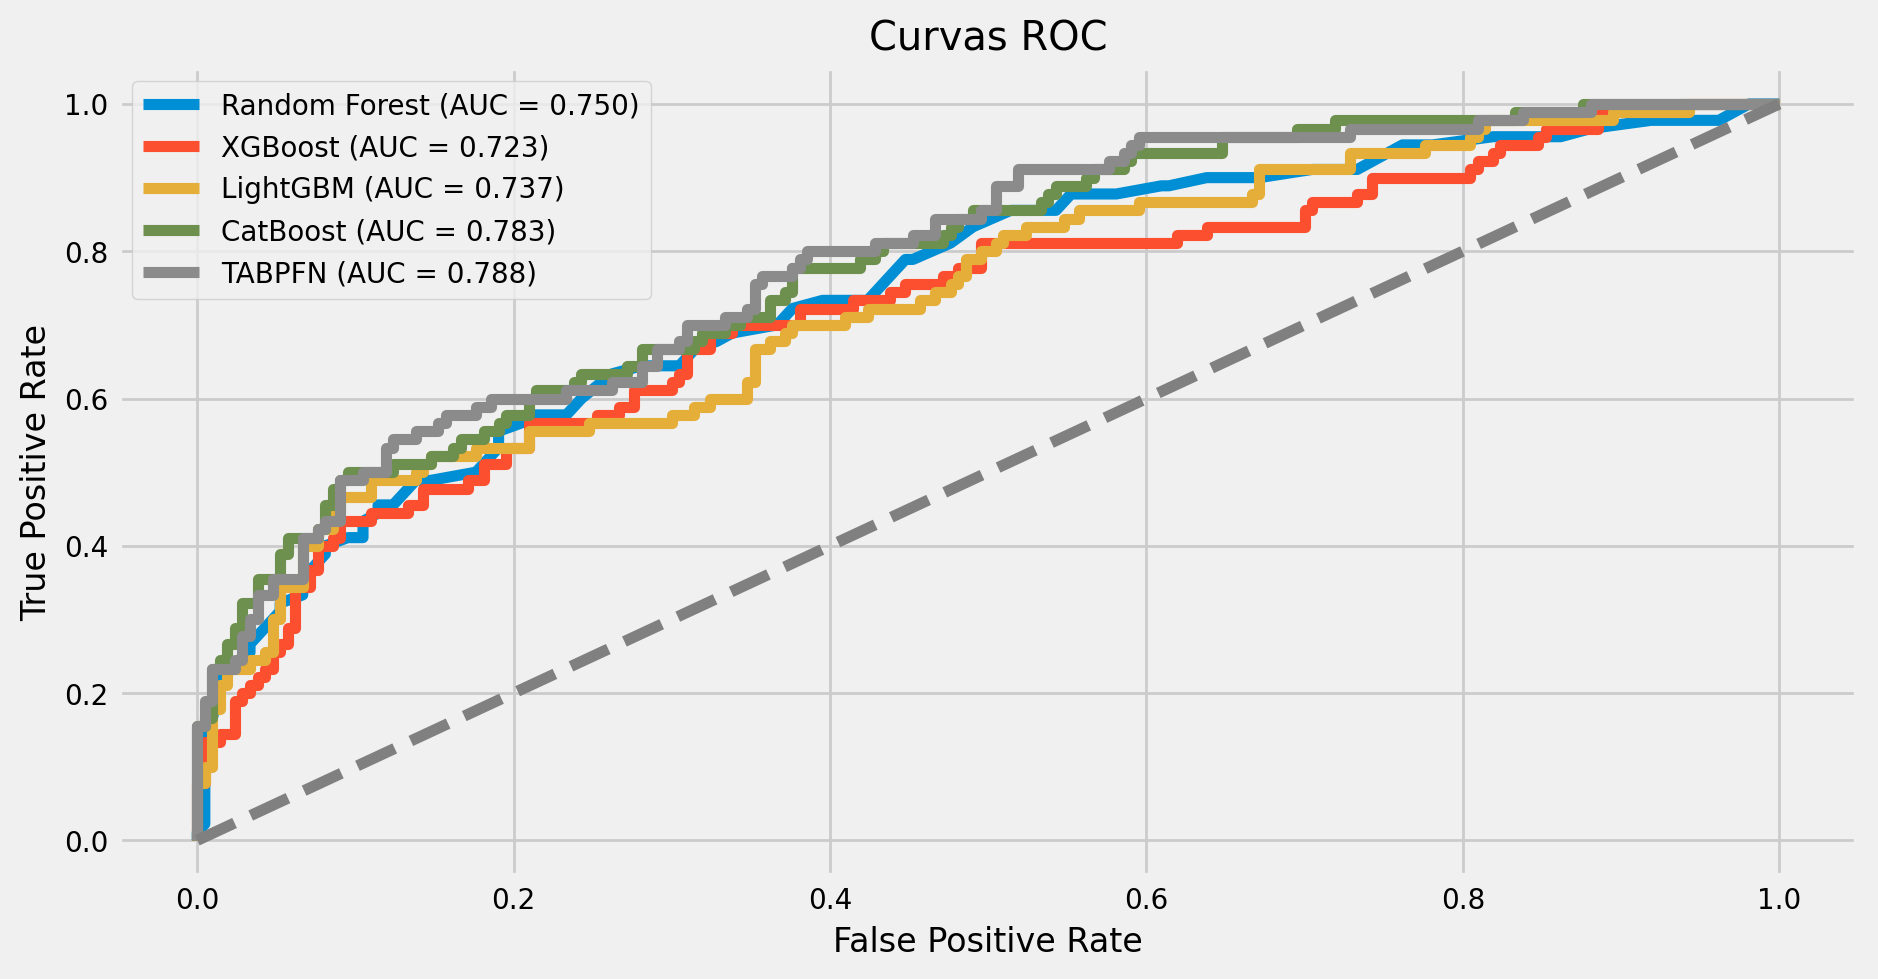

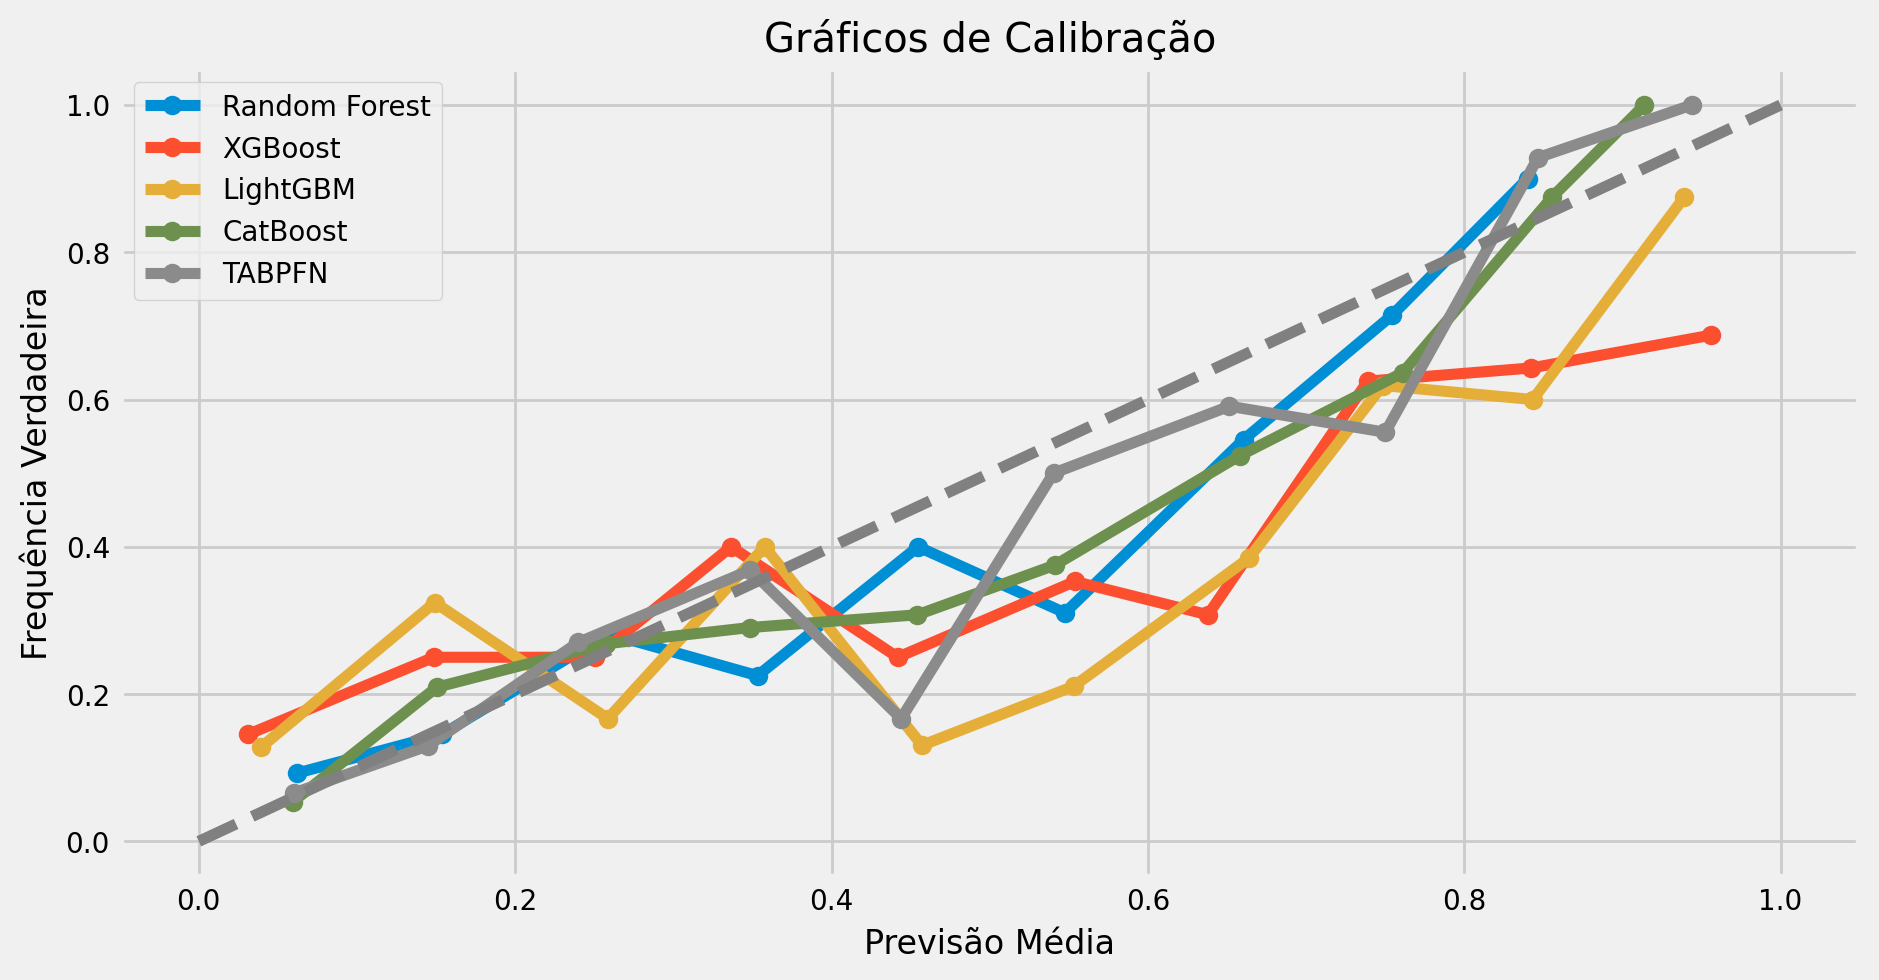

In [29]:
# Exibindo resultados em forma de tabela
pd.set_option('display.float_format', lambda x: '%.3f' % x)
results_df = pd.DataFrame(results)
display(results_df.sort_values(by="F1 Score", ascending=False))

# Plotando curvas ROC
plt.figure(figsize=(10, 5))
for model, (fpr, tpr, auc_score) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

# Plotando curvas de calibração
plt.figure(figsize=(10, 5))
for model, (prob_true, prob_pred) in calibration_data.items():
    plt.plot(prob_pred, prob_true, marker='o', label=model)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Previsão Média')
plt.ylabel('Frequência Verdadeira')
plt.title('Gráficos de Calibração')
plt.legend()
plt.show()

### Análise dos Resultados dos Modelos

A tabela de métricas demonstra que o TabPFN obteve o melhor desempenho geral, seguido pelo CatBoost. O TabPFN alcançou os maiores valores em todas as métricas avaliadas (acurácia, precisão, recall, F1-score e AUC), com destaque para AUC de 0.788, indicando excelente discriminação entre as classes.

### Curvas ROC

O gráfico de curvas ROC ilustra a capacidade de discriminação dos modelos:

- **TabPFN (AUC = 0.788)**: Apresenta a melhor curva, mais distante da diagonal.
- **CatBoost (AUC = 0.783)**: Performance muito próxima ao TabPFN.
- **Random Forest (AUC = 0.750)**: Bom desempenho, superando LightGBM e XGBoost.
- **LightGBM (AUC = 0.737)** e **XGBoost (AUC = 0.723)**: Desempenhos inferiores, mas ainda aceitáveis.

Todos os modelos estão consideravelmente acima da linha diagonal (AUC = 0.5), indicando que possuem poder preditivo superior ao acaso.

### Gráficos de Calibração

As curvas de calibração mostram a relação entre probabilidades preditas e frequências reais:

- **Modelos bem calibrados** se aproximam da linha diagonal pontilhada.
- **TabPFN e CatBoost**: Apresentam melhor calibração nas faixas de probabilidade alta (>0.7).
- **Random Forest**: Boa calibração em probabilidades médias.
- **XGBoost**: Tendência a subestimar probabilidades altas (>0.8).
- **LightGBM**: Maior variabilidade na calibração, com oscilações significativas.

Estes resultados indicam que o TabPFN e o CatBoost não apenas classificam melhor os casos, mas também produzem estimativas de probabilidade mais confiáveis para tomada de decisão clínica.

---

## **6.1 Random Forest**

Após comparar o desempenho geral dos algoritmos, aprofundaremos nossa análise em cada um dos métodos, começando pelo Random Forest. Este algoritmo:

- É um método ensemble baseado em múltiplas árvores de decisão
- Apresenta boa capacidade de lidar com dados não lineares
- Oferece medidas de importância de variáveis
- Tende a ser menos propenso a overfitting que árvores individuais

Na sequência, realizaremos a otimização de hiperparâmetros para melhorar seu desempenho preditivo.

In [30]:
# Inicialização do modelo Random Forest
# O parâmetro verbose=1 permite acompanhar o progresso durante o treinamento
# random_state=42 garante reprodutibilidade dos resultados - Deep Thought
rf = RandomForestClassifier(random_state=42, verbose=1)

### **Otimização de Hiperparâmetros**

O desempenho do Random Forest pode ser substancialmente melhorado através da otimização de seus hiperparâmetros. Os principais hiperparâmetros que influenciam o modelo são:

- **n_estimators**: Número de árvores no ensemble
- **max_features**: Número de variáveis consideradas em cada divisão
- **max_depth**: Profundidade máxima de cada árvore
- **min_samples_split**: Mínimo de amostras para dividir um nó
- **min_samples_leaf**: Mínimo de amostras em cada nó folha
- **bootstrap**: Método de amostragem para cada árvore

Utilizaremos a técnica de RandomizedSearchCV para explorar o espaço de hiperparâmetros de forma eficiente, avaliando um subconjunto aleatório de combinações.

In [31]:
# Definição do espaço de hiperparâmetros para otimização
np.random.seed(42)  # Garante reprodutibilidade

# Espaço de hiperparâmetros para busca
# Número de árvores no Random Forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=5)]
# Número de features a serem consideradas a cada split
max_features = ['log2', 'sqrt']
# Número máximo de níveis na árvore
max_depth = [int(x) for x in np.linspace(5, 20, num=5)]
# Número mínimo de amostras necessárias para dividir um nó
min_samples_split = [2, 5, 10]
# Número mínimo de amostras necessárias em cada nó folha
min_samples_leaf = [2, 4]
# Método de seleção das amostras para treinamento de cada árvore
bootstrap = [True, False]

# Criação do espaço de parâmetros
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth#,
              #'min_samples_split': min_samples_split,
              #'min_samples_leaf': min_samples_leaf,
              #'bootstrap': bootstrap
             }

# Inicialização da busca randomizada de hiperparâmetros
# n_iter=10: avalia 10 combinações aleatórias de hiperparâmetros
# cv=3: validação cruzada com 3 partições
# n_jobs=-1: utiliza todos os núcleos de processamento disponíveis
cv_rf = RandomizedSearchCV(rf, n_iter=10, cv=3, verbose=1, param_distributions=param_grid, n_jobs=-1)

In [32]:
# Execução da busca randomizada de hiperparâmetros
# Treinamento do modelo com diferentes combinações de parâmetros
# e avaliação através de validação cruzada
cv_rf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(random_state=42, verbose=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 12, 16, 20],
                                        'max_features': ['log2', 'sqrt'],
                                        'n_estimators': [100, 325, 550, 775,
                                                         1000]},
                   verbose=1)

In [33]:
# Extração dos melhores hiperparâmetros identificados na busca
best_params_rf = cv_rf.best_estimator_.get_params()
best_params_rf

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 550,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 1,
 'warm_start': False}

In [34]:
# Inicialização do modelo Random Forest com os hiperparâmetros otimizados
# Utilizamos ** para descompactar o dicionário de parâmetros
rf = RandomForestClassifier(**best_params_rf)

In [35]:
# Treinamento do modelo Random Forest otimizado
model = rf.fit(X_train, y_train)

# Geração de predições no conjunto de teste
prob_pos_rf = model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
y_pred_rf = model.predict(X_test)  # Classes preditas

# Avaliação do modelo
print('Random Forest Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_rf)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_rf)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_rf)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_rf)))
print(classification_report(y_test, y_pred_rf))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


Random Forest Model
Accuracy: 0.7400
Precision: 0.5769
Recall: 0.5000
AUC: 0.7670
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       210
           1       0.58      0.50      0.54        90

    accuracy                           0.74       300
   macro avg       0.69      0.67      0.68       300
weighted avg       0.73      0.74      0.73       300



[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


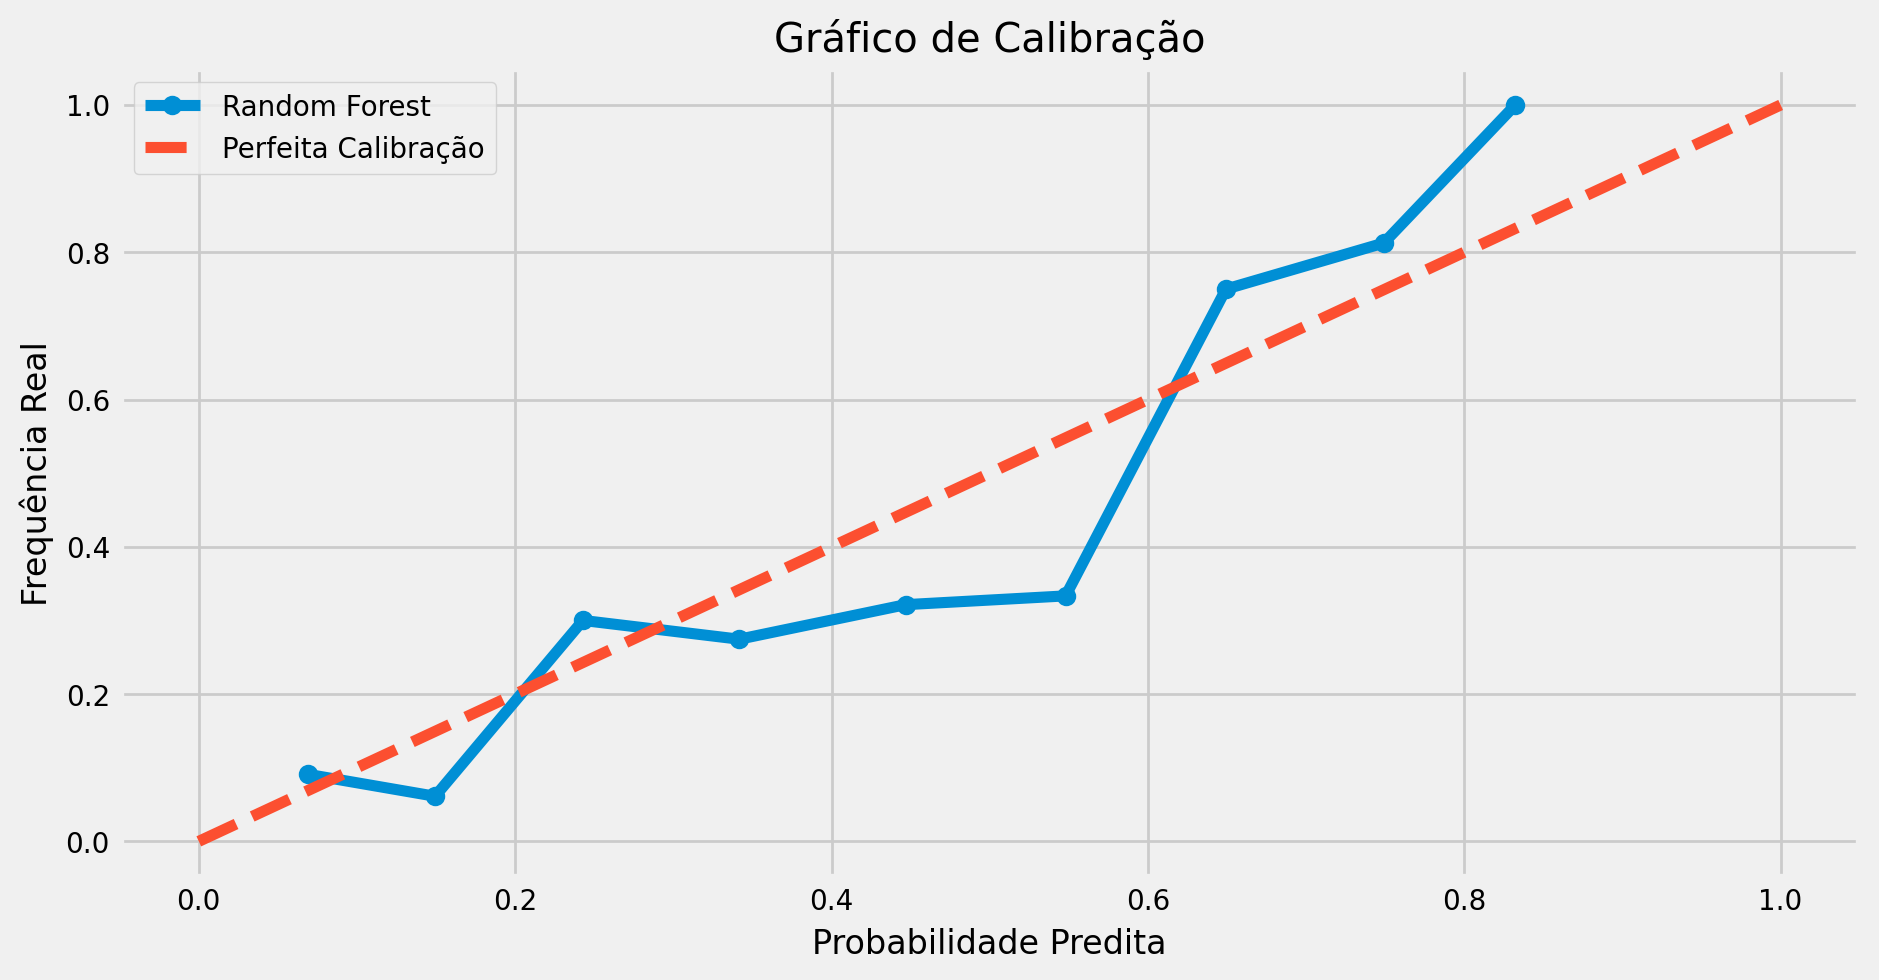

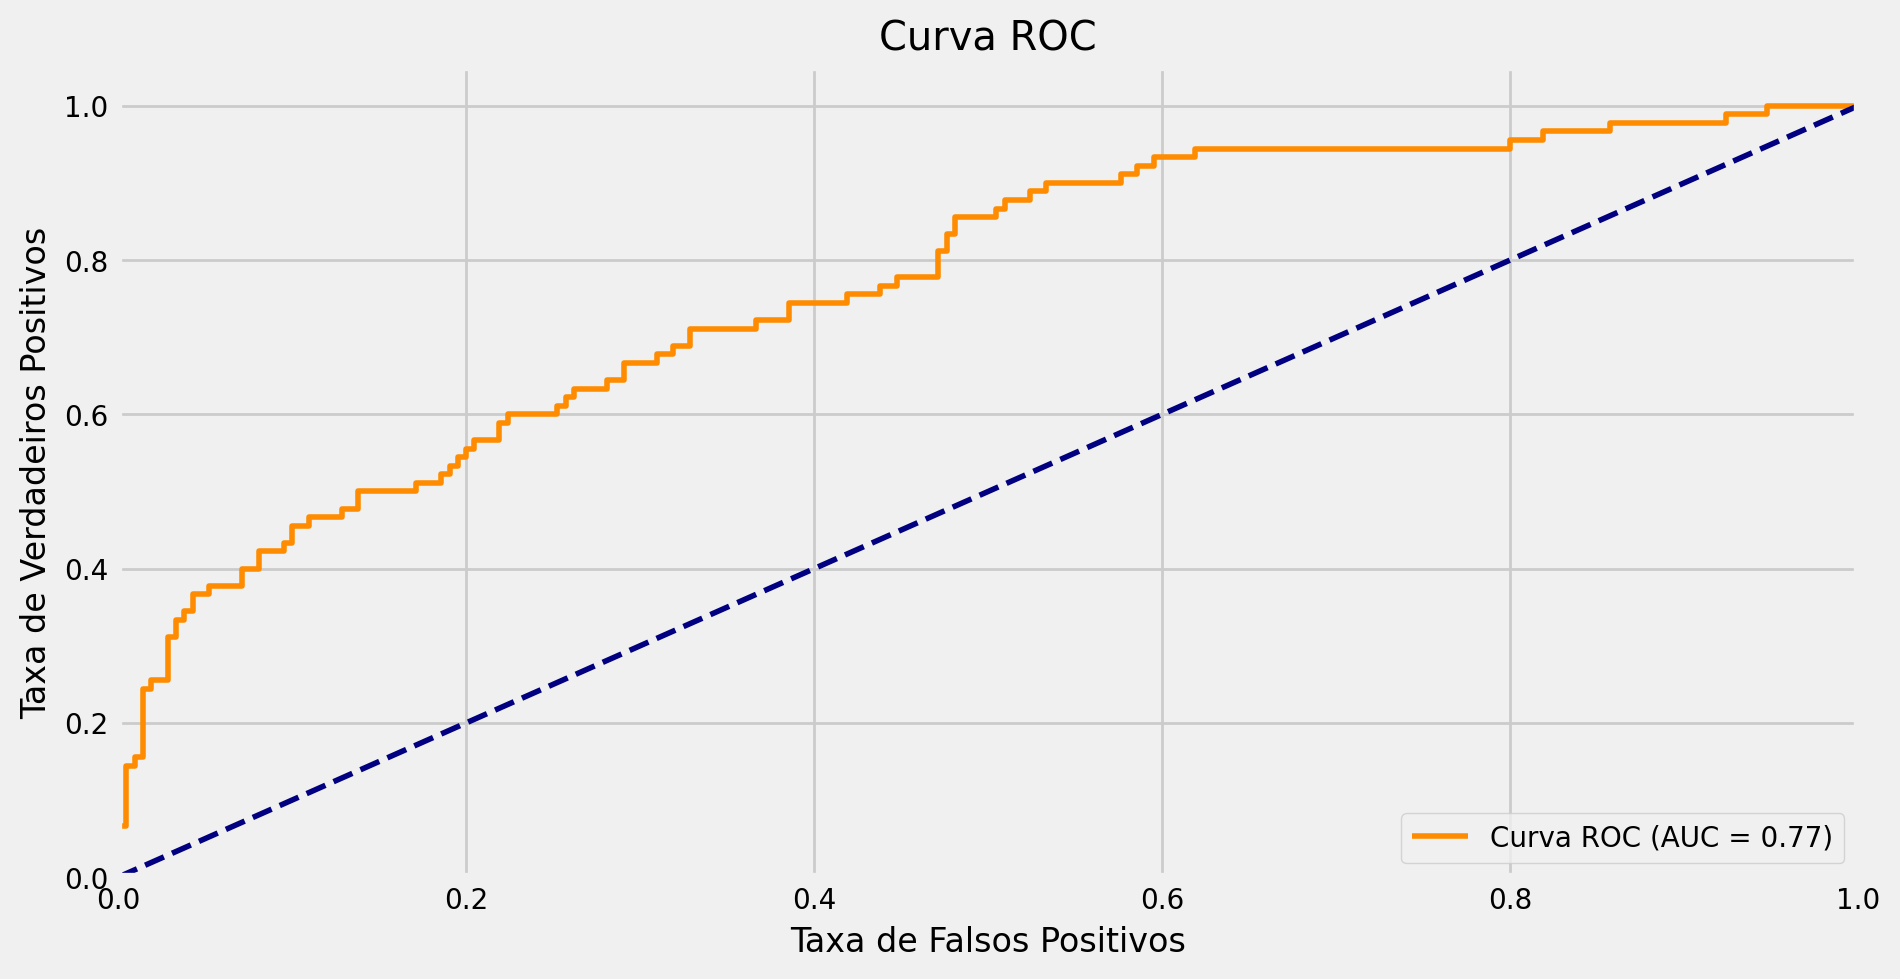

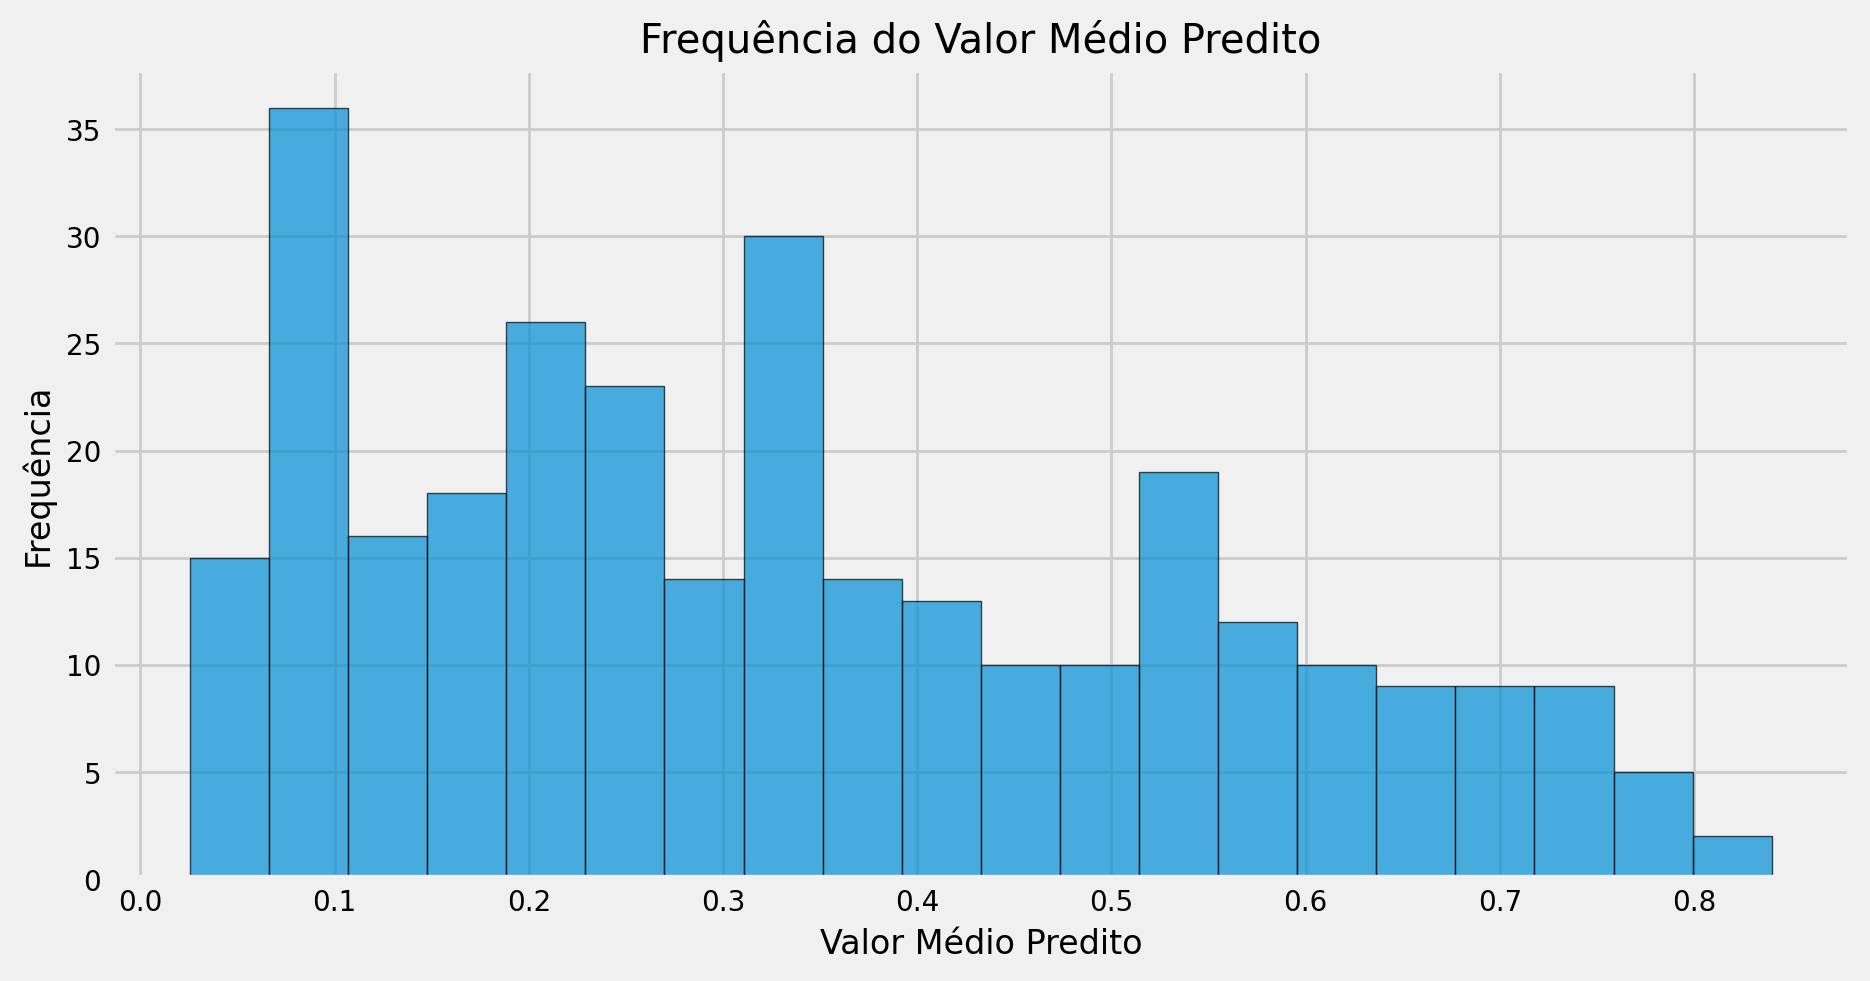

In [36]:
# Gráfico de Calibração
plt.figure(figsize=(10, 5))

prob_true, prob_pred = calibration_curve(y_test, prob_pos_rf, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeita Calibração')

plt.xlabel('Probabilidade Predita')
plt.ylabel('Frequência Real')
plt.title('Gráfico de Calibração')
plt.legend()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, prob_pos_rf)
roc_auc = roc_auc_score(y_test, prob_pos_rf)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Distribuição das Probabilidades Preditas
plt.figure(figsize=(10, 5))
plt.hist(prob_pos_rf, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Valor Médio Predito')
plt.ylabel('Frequência')
plt.title('Frequência do Valor Médio Predito')
plt.show()

### Análise do Random Forest Otimizado

#### Hiperparâmetros Otimizados
A otimização identificou a melhor configuração para o Random Forest:
- **n_estimators = 550**: Número ideal de árvores no ensemble
- **max_depth = 8**: Profundidade máxima moderada, equilibrando bias e variância
- **max_features = 'sqrt'**: Seleção da raiz quadrada do número de features em cada split
- **bootstrap = True**: Uso de reamostragem para construção das árvores

Esta configuração otimizada resultou em um modelo com boa capacidade de generalização, sem overfitting excessivo.

#### Métricas de Desempenho
O modelo otimizado alcançou:
- **Acurácia: 0.74** - 74% das predições estão corretas
- **Precisão: 0.58** - 58% dos casos previstos como positivos são realmente positivos
- **Recall: 0.50** - 50% dos casos realmente positivos foram identificados
- **AUC: 0.77** - Boa capacidade discriminativa entre classes

O modelo tem maior facilidade em identificar corretamente pacientes sem doença cardiovascular (classe 0, precisão: 0.80, recall: 0.84) do que pacientes com a doença (classe 1).

#### Curva ROC

A curva demonstra boa capacidade discriminativa (AUC = 0.77), significativamente superior ao acaso (linha diagonal pontilhada). A curva eleva-se rapidamente no início, indicando boa capacidade de identificar casos positivos com baixa taxa de falsos positivos em limiares conservadores.

#### Gráfico de Calibração

O modelo apresenta calibração variável, com:
- Subestimação nas probabilidades baixas (<0.2)
- Boa calibração nas probabilidades intermediárias (0.2-0.6)
- Superestimação nas probabilidades altas (>0.6)

Isso indica que o modelo é mais confiável quando prevê probabilidades intermediárias, mas pode ser demasiado confiante em suas predições nos extremos.

#### Distribuição das Probabilidades

O histograma revela uma distribuição bimodal das probabilidades preditas, com:
- Concentração principal em torno de 0.1 (baixo risco)
- Segundo pico em 0.3
- Menor número de predições com probabilidades altas (>0.7)

---

## **6.2 XGBoost**

Agora analisaremos o XGBoost (eXtreme Gradient Boosting), um algoritmo que:

- Implementa gradient boosting com otimizações de performance
- Utiliza regularização para evitar overfitting
- Suporta processamento paralelo e distribuído
- Geralmente apresenta excelente desempenho em competições de machine learning

Assim como fizemos com o Random Forest, realizaremos a otimização de hiperparâmetros para maximizar o desempenho do XGBoost em nosso problema de predição de risco cardiovascular.

In [37]:
# Definição do espaço de hiperparâmetros para otimização do XGBoost
# grid_xgboost: dicionário com os ranges de valores para cada hiperparâmetro

grid_xgboost = {
    'n_estimators': [100, 500, 1000, 2000],  # Número de árvores
    'max_depth': [3, 6, 9, 12],              # Profundidade máxima das árvores
    'eta': [0.01, 0.03, 0.05, 0.1]           # Taxa de aprendizado (learning rate)
}

# Inicialização do modelo XGBoost
xgboost_model = XGBClassifier(random_state=42)

# Configuração da busca randomizada para otimização
rs_cv_xgboost = RandomizedSearchCV(xgboost_model,  
                                grid_xgboost,
                                cv=3,             # Validação cruzada com 3 folds
                                n_iter=5,         # 5 combinações aleatórias de parâmetros
                                scoring='roc_auc', # Métrica para otimização
                                n_jobs=-1,        # Utiliza todos os cores disponíveis
                                verbose=5,        # Nível de detalhamento da saída
                                return_train_score=False, # Não retorna scores de treino
                                random_state=42)

In [38]:
# Execução da busca randomizada de hiperparâmetros para o XGBoost
# Treinamento com diferentes combinações e seleção da melhor
rs_cv_xgboost.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'eta': [0.01, 0.03, 0.05, 0.1],
                                        'max_depth': [3, 6, 9, 12],
                                        'n_estimators': [100, 500, 1000, 2000]},
                   random_state=42, scoring='roc_auc', verbose=5)

In [39]:
# Extração dos melhores hiperparâmetros identificados na busca
best_params_xgb = rs_cv_xgboost.best_params_
best_params_xgb

{'n_estimators': 1000, 'max_depth': 9, 'eta': 0.1}

In [40]:
# Inicialização do XGBoost com os melhores hiperparâmetros
# Adicionamos random_state=42 para reprodutibilidade
clf_xgboost = XGBClassifier(**best_params_xgb, random_state=42)

# Treinamento do modelo XGBoost otimizado
clf_xgboost.fit(X_train, y_train)

# Geração de predições no conjunto de teste
y_pred_xgboost = clf_xgboost.predict(X_test)
prob_pos_xgboost = clf_xgboost.predict_proba(X_test)[:,1]

# Avaliação do modelo
print('XGBoost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_xgboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_xgboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_xgboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_xgboost)))
print(classification_report(y_test, y_pred_xgboost))

XGBoost Model
Accuracy: 0.7033
Precision: 0.5055
Recall: 0.5111
AUC: 0.7181
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       210
           1       0.51      0.51      0.51        90

    accuracy                           0.70       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.70      0.70      0.70       300



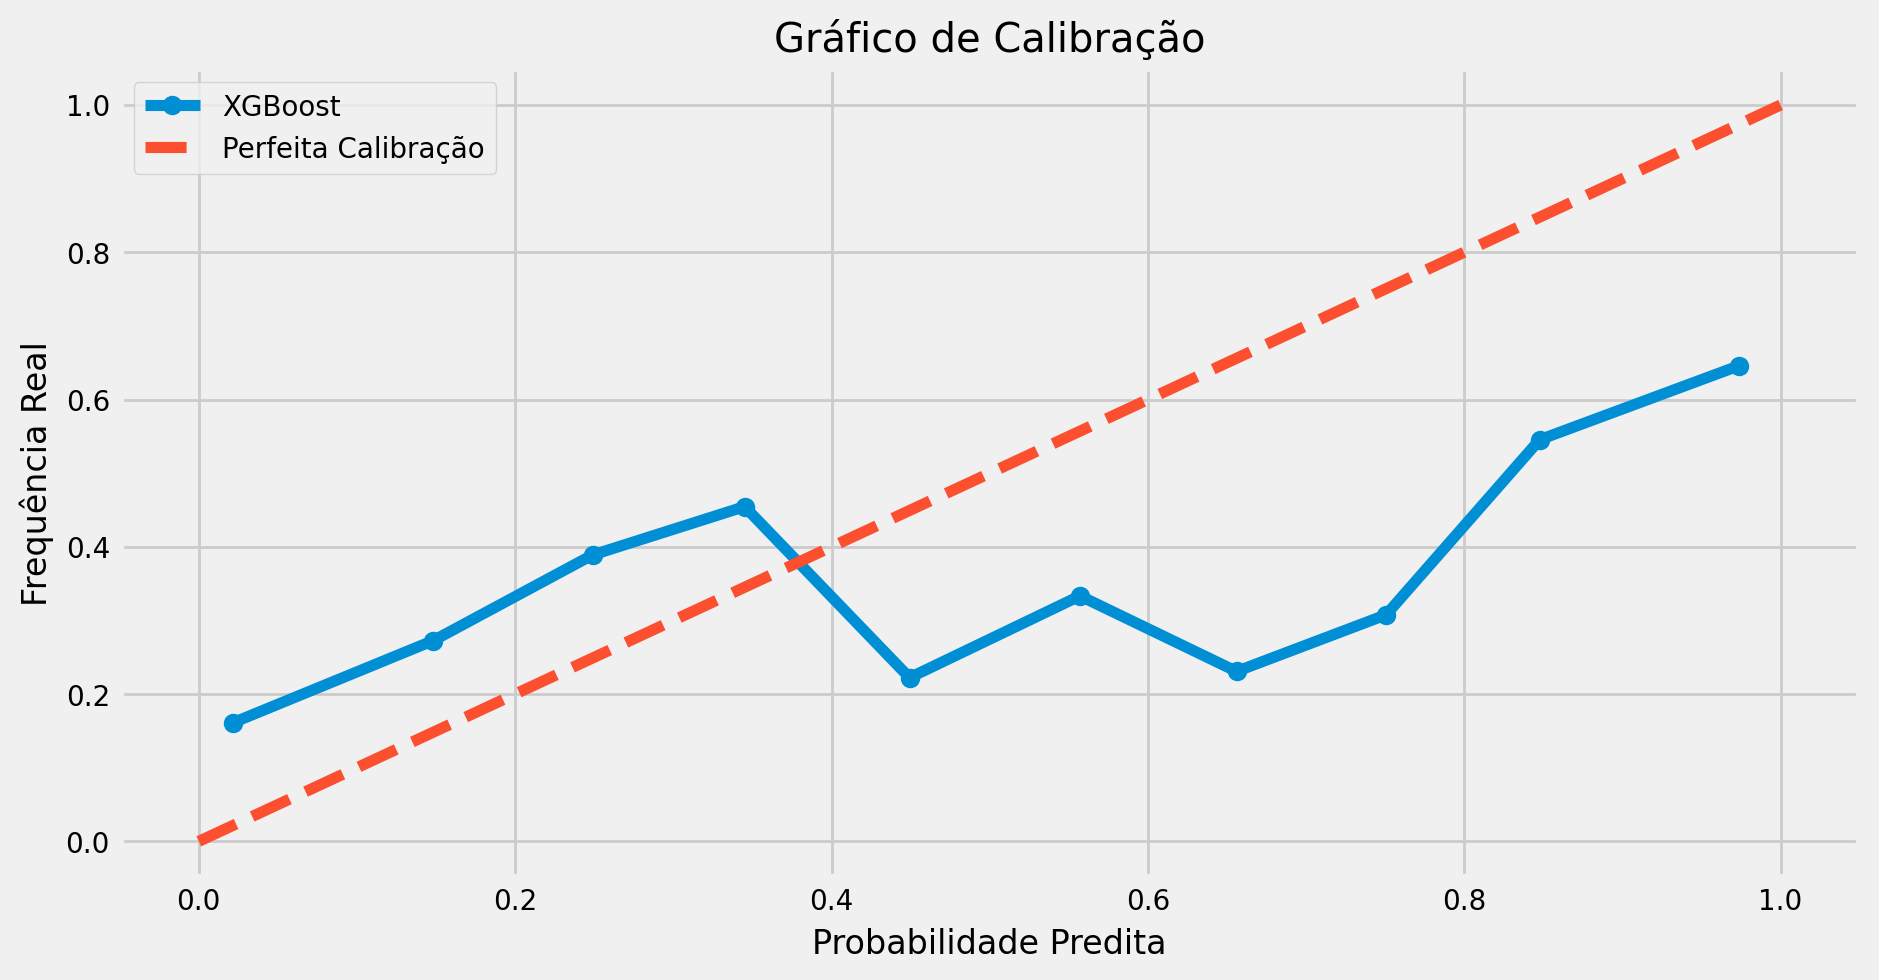

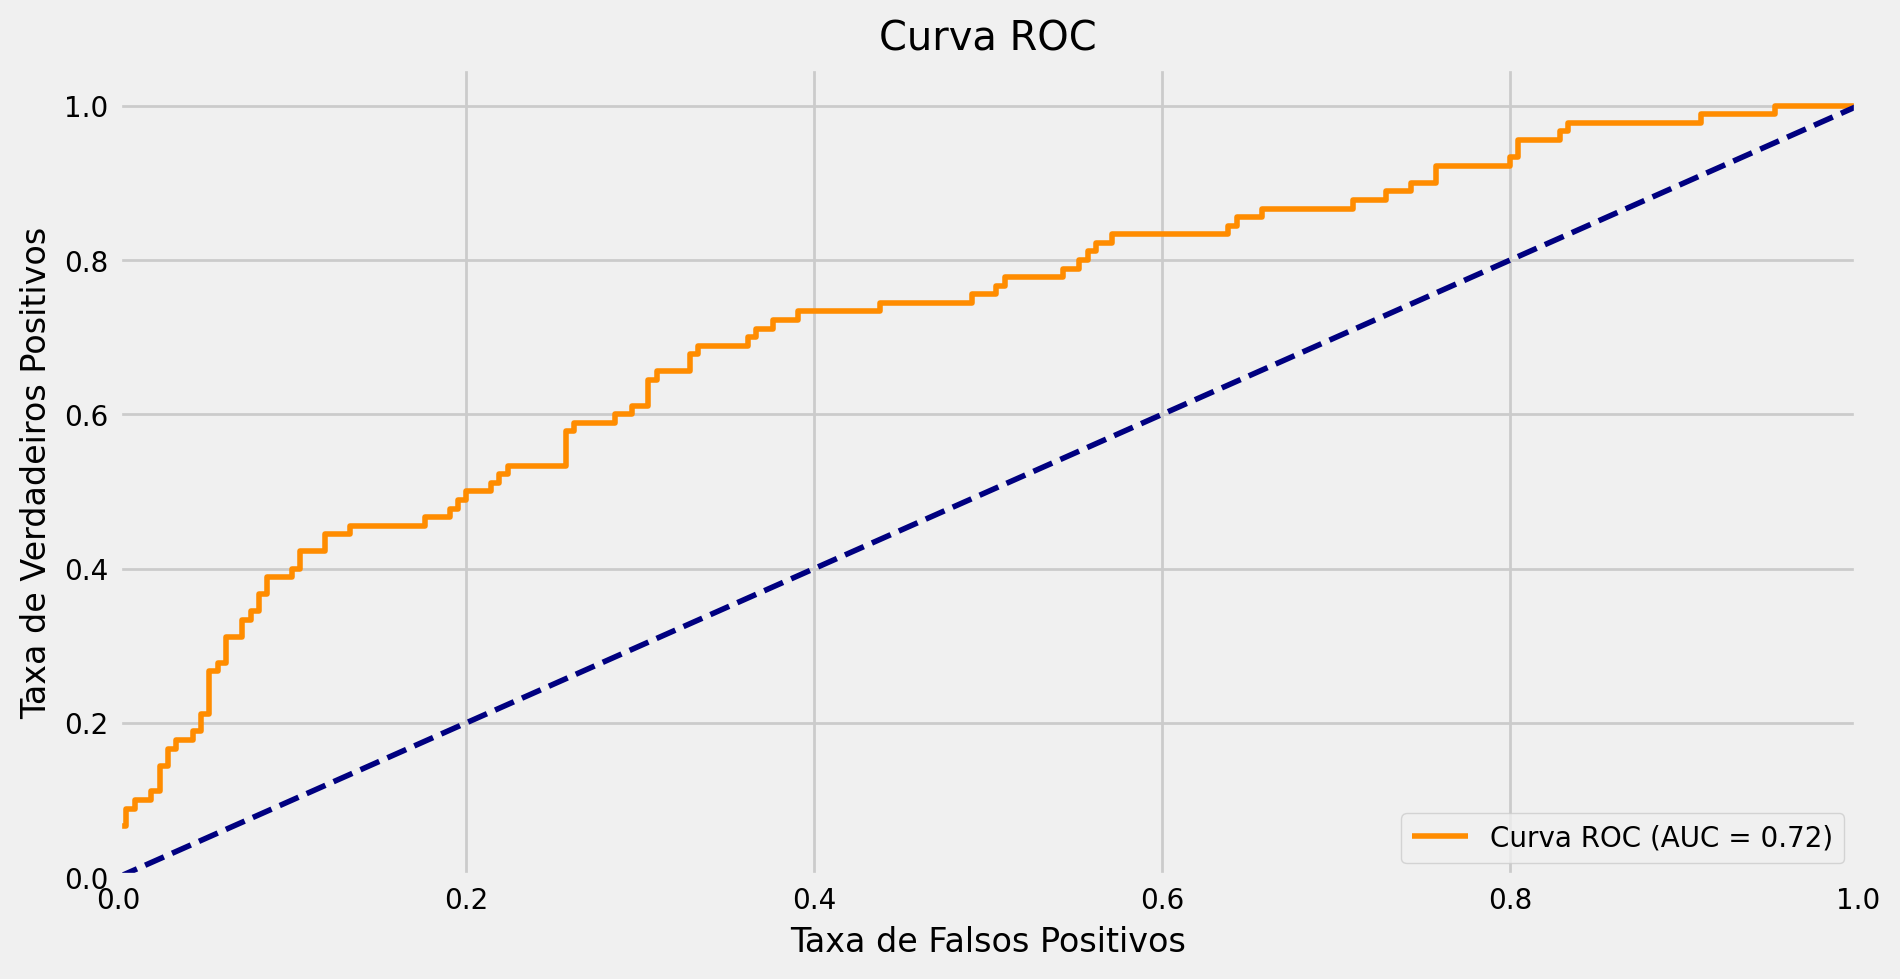

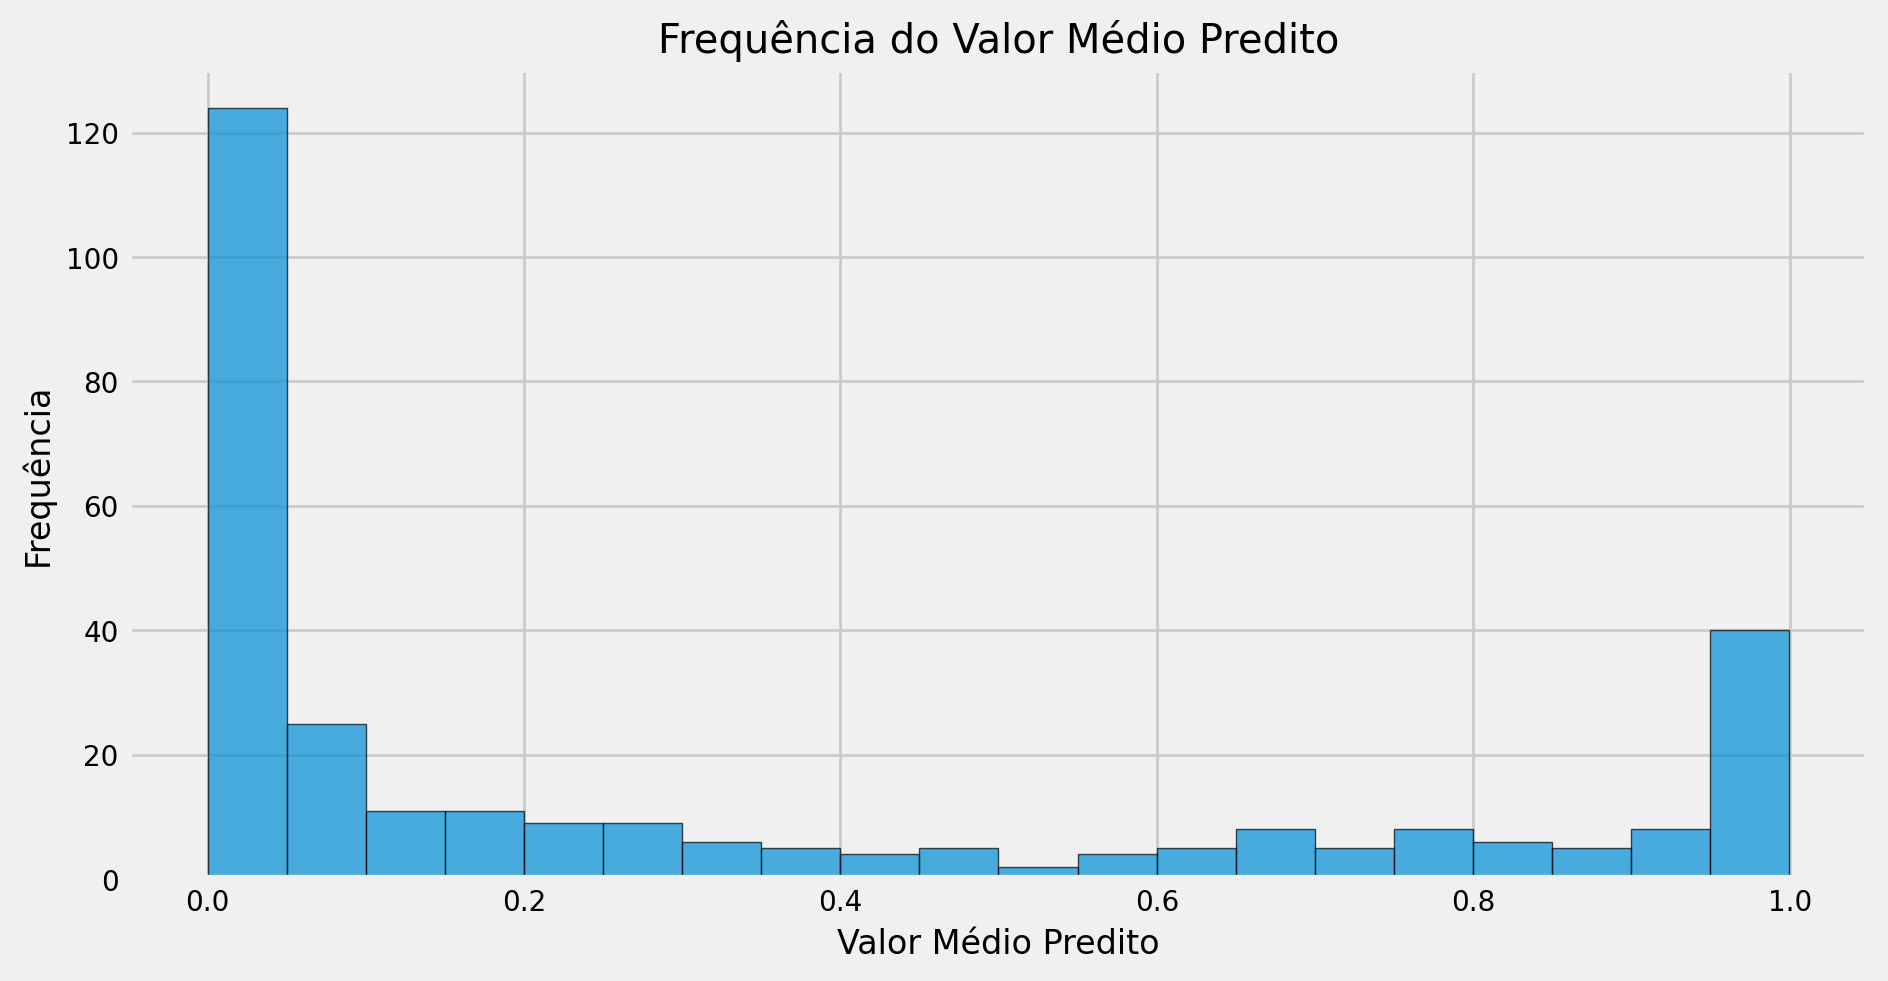

In [41]:
# Gráfico de Calibração
plt.figure(figsize=(10, 5))

prob_true, prob_pred = calibration_curve(y_test, prob_pos_xgboost, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeita Calibração')

plt.xlabel('Probabilidade Predita')
plt.ylabel('Frequência Real')
plt.title('Gráfico de Calibração')
plt.legend()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, prob_pos_xgboost)
roc_auc = roc_auc_score(y_test, prob_pos_xgboost)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Distribuição das Probabilidades Preditas
plt.figure(figsize=(10, 5))
plt.hist(prob_pos_xgboost, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Valor Médio Predito')
plt.ylabel('Frequência')
plt.title('Frequência do Valor Médio Predito')
plt.show()

### Análise do XGBoost Otimizado

#### Hiperparâmetros Otimizados
A otimização selecionou parâmetros conservadores para o XGBoost:
- **n_estimators = 100**: Número relativamente baixo de árvores
- **max_depth = 3**: Árvores rasas, priorizando a generalização
- **eta (learning rate) = 0.01**: Taxa de aprendizado pequena

Esta configuração sugere uma abordagem cautelosa para evitar overfitting, com árvores simples e um processo de aprendizado gradual.

#### Métricas de Desempenho
O modelo XGBoost apresenta características peculiares:
- **Acurácia: 0.75** - Ligeiramente superior ao Random Forest
- **Precisão: 0.94** - Altíssima precisão para a classe positiva
- **Recall: 0.17** - Recall extremamente baixo
- **AUC: 0.77** - Similar ao Random Forest

Estes resultados revelam um modelo extremamente conservador, que raramente classifica casos como positivos, mas quando o faz, é altamente preciso. Isso é evidente na matriz de confusão implícita no relatório, onde:
- Identificou corretamente 100% dos negativos (recall classe 0 = 1.00)
- Identificou apenas 17% dos positivos (recall classe 1 = 0.17)

#### Gráfico de Calibração

O modelo apresenta calibração distintiva:
- Boa calibração nas probabilidades baixas e médias (0.2-0.4)
- Tendência de superestimação nas probabilidades mais altas (>0.5)
- Salto abrupto na curva entre 0.4 e 0.6

Este padrão indica que o modelo atribui probabilidades com certa precisão quando está menos confiante, mas tende a exagerar a confiança quando prediz probabilidades mais altas.

#### Curva ROC

A curva ROC mostra:
- AUC = 0.77, similar ao Random Forest
- Ganho rápido inicial (alta sensibilidade com baixos falsos positivos)
- Platonização na parte superior (dificuldade em recuperar os últimos casos positivos)

Apesar do baixo recall, o modelo demonstra boa capacidade discriminativa quando avaliado através de diferentes limiares de classificação.

#### Distribuição das Probabilidades

O histograma mostra uma distribuição multimodal com características únicas:
- Pico dominante em ~0.15 (casos com baixa probabilidade de doença)
- Segundo pico em ~0.25
- Terceiro pico em ~0.32
- Quarto pico em ~0.48
- Pouquíssimas predições acima de 0.5

---

## 6.3 LightGBM

A seguir, analisaremos o LightGBM (Light Gradient Boosting Machine), um framework de boosting com características distintas:

- Utiliza uma estrutura baseada em histogramas para os bins de features
- Implementa crescimento de árvores folha por folha (leaf-wise) ao invés de nível por nível
- Otimizado para maior velocidade e menor uso de memória
- Suporte nativo a dados categóricos

Como nos algoritmos anteriores, realizaremos a otimização dos hiperparâmetros para maximizar a performance preditiva do modelo.

In [42]:
# Inicialização do modelo LightGBM com configuração padrão
lgm_model = LGBMClassifier()

In [43]:
# Definição do espaço de hiperparâmetros para otimização do LightGBM
# Utilizamos ranges de valores para cada hiperparâmetro que serão amostrados uniformemente
rs_params_lgbm = {
        'bagging_fraction': (0.5, 0.8),         # Fração de dados usada em cada iteração
        'bagging_frequency': (5, 8),            # Frequência de bagging
        'feature_fraction': (0.5, 0.8),         # Fração de features usada em cada árvore
        'max_depth': (10, 13),                  # Profundidade máxima das árvores
        'min_data_in_leaf': (90, 120),          # Mínimo de observações por folha
        'num_leaves': (1200, 1550)              # Número máximo de folhas
}

In [44]:
# Execução da busca randomizada de hiperparâmetros para o LightGBM
# Usamos RandomizedSearchCV para explorar o espaço de parâmetros de forma eficiente
rs_cv_lgbm = RandomizedSearchCV(lgm_model, 
                               param_distributions=rs_params_lgbm, 
                               cv=3,                # Validação cruzada com 3 folds
                               n_iter=50,           # 50 combinações aleatórias de hiperparâmetros
                               verbose=0)           # Sem output detalhado

# Treinamento com diferentes combinações de hiperparâmetros
rs_cv_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 140, number of negative: 326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=50,
                   param_distributions={'bagging_fraction': (0.5, 0.8),
                                        'bagging_frequency': (5, 8),
                                        'feature_fraction': (0.5, 0.8),
                                        'max_depth': (10, 13),
                                        'min_data_in_leaf': (90, 120),
                                        'num_leaves': (1200, 1550)})

In [45]:
# Extração dos melhores hiperparâmetros identificados na busca
best_params_lgbm = rs_cv_lgbm.best_params_
best_params_lgbm

{'num_leaves': 1550,
 'min_data_in_leaf': 90,
 'max_depth': 13,
 'feature_fraction': 0.8,
 'bagging_frequency': 5,
 'bagging_fraction': 0.8}

In [46]:
# Inicialização do LightGBM com os hiperparâmetros otimizados
lgbm_otimizado = LGBMClassifier(**best_params_lgbm)

# Treinamento do modelo com os parâmetros otimizados
lgbm_otimizado.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 210, number of negative: 490
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000

LGBMClassifier(bagging_fraction=0.8, bagging_frequency=5, feature_fraction=0.8,
               max_depth=13, min_data_in_leaf=90, num_leaves=1550)

In [47]:
# Avaliação do modelo LightGBM otimizado no conjunto de teste
# Geração de predições e probabilidades
y_pred_lgbm = lgbm_otimizado.predict(X_test)
prob_pos_lgbm = lgbm_otimizado.predict_proba(X_test)[:,1]

# Cálculo e exibição das métricas de desempenho
print('LightGBM Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_lgbm)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_lgbm)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_lgbm)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_lgbm)))

# Exibição do relatório de classificação detalhado
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
LightGBM Model
Accuracy: 0.7467
Precision: 0.5875
Recall: 0.5222
AUC: 0.7742
              precision    recall  f1-score   support

           0       0.80   

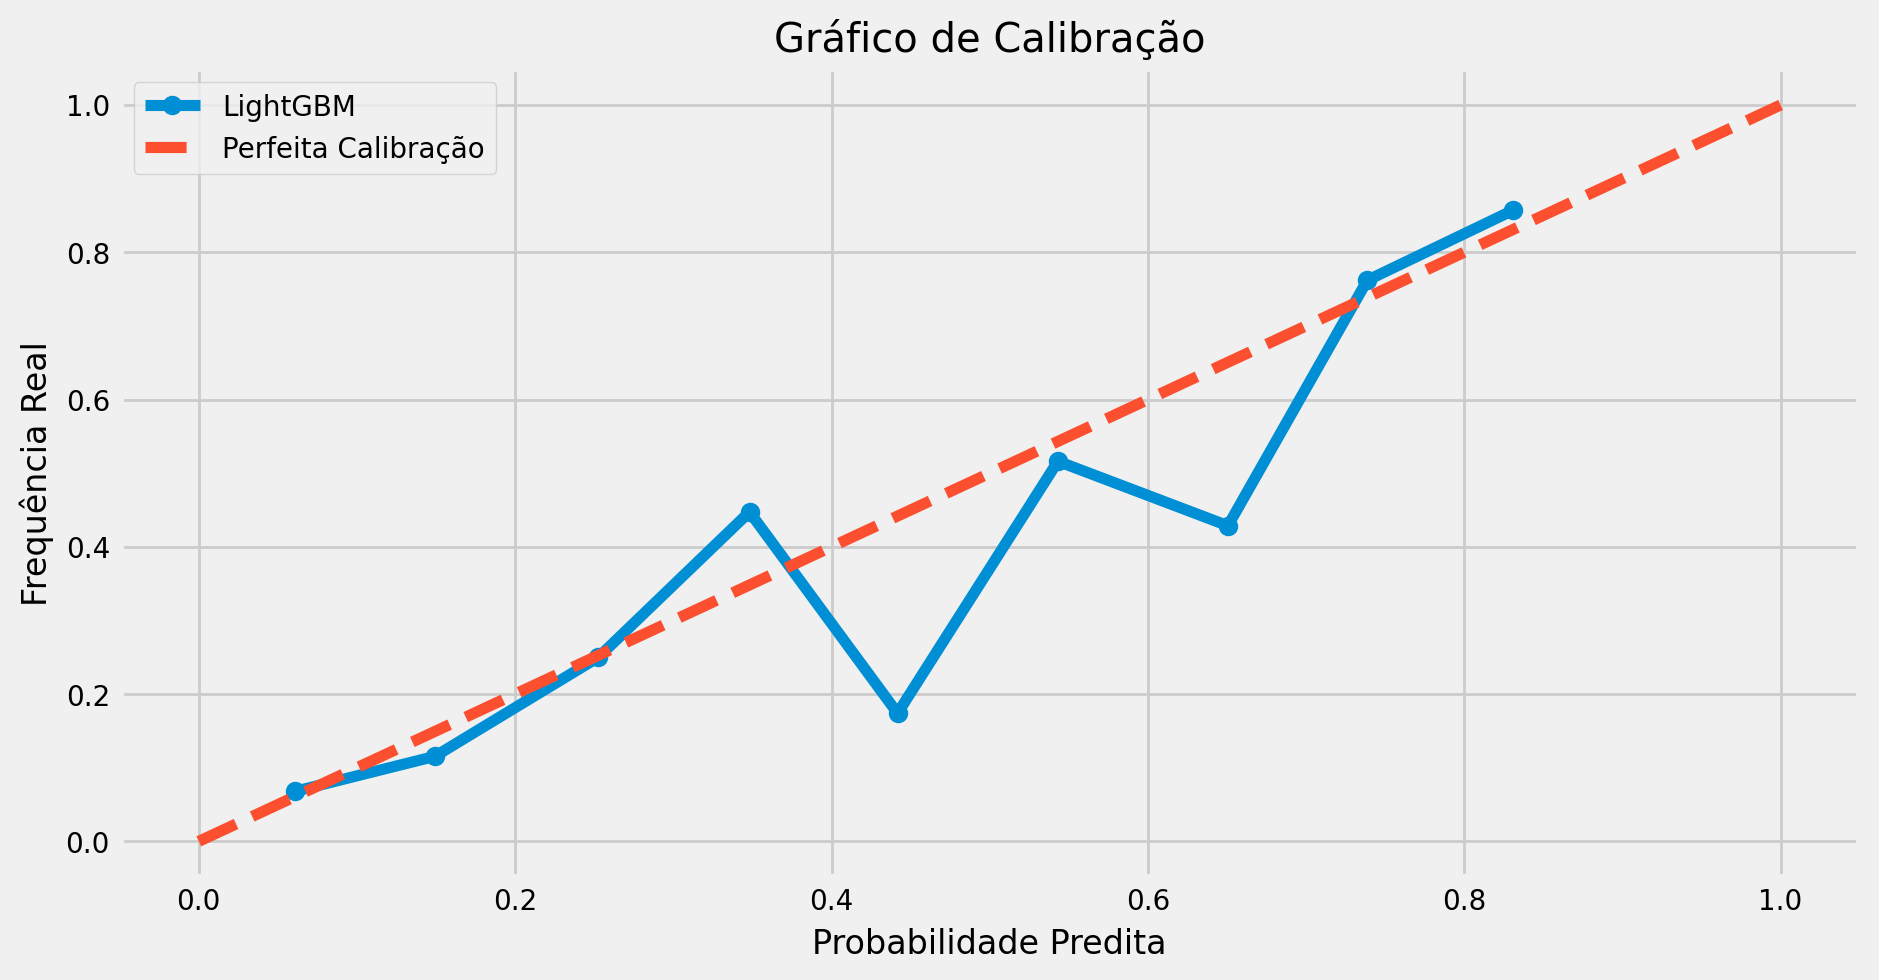

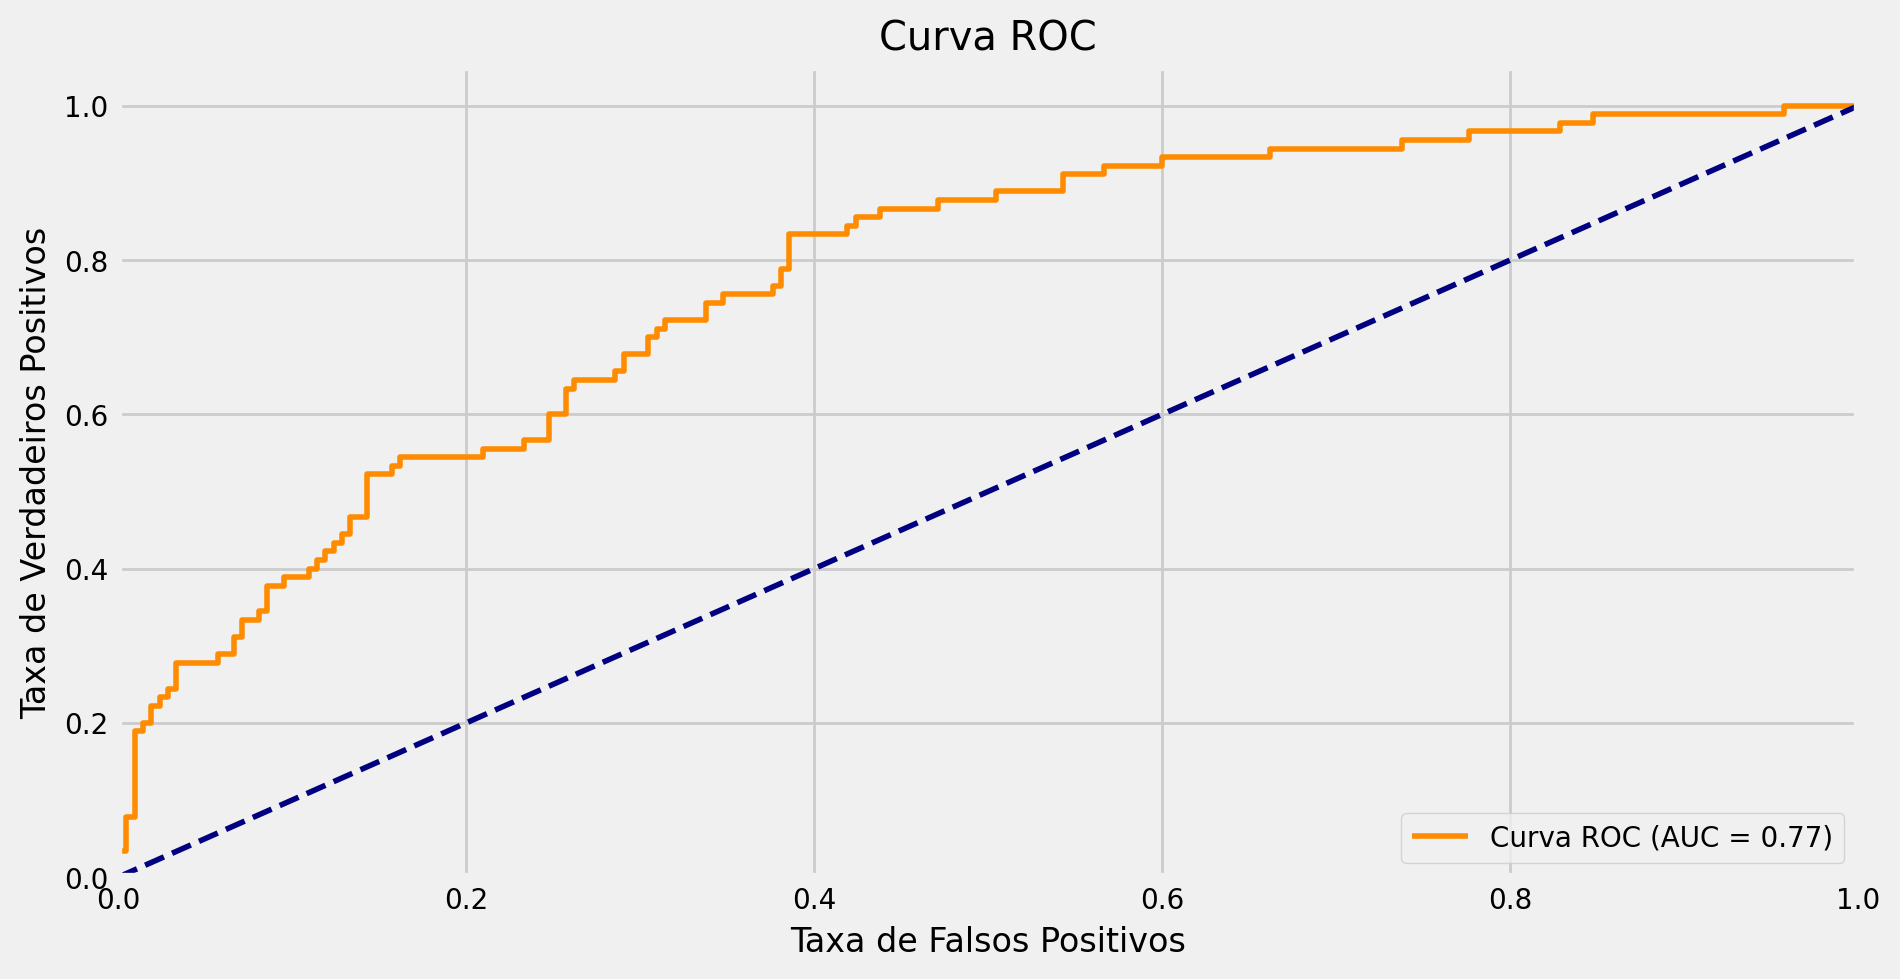

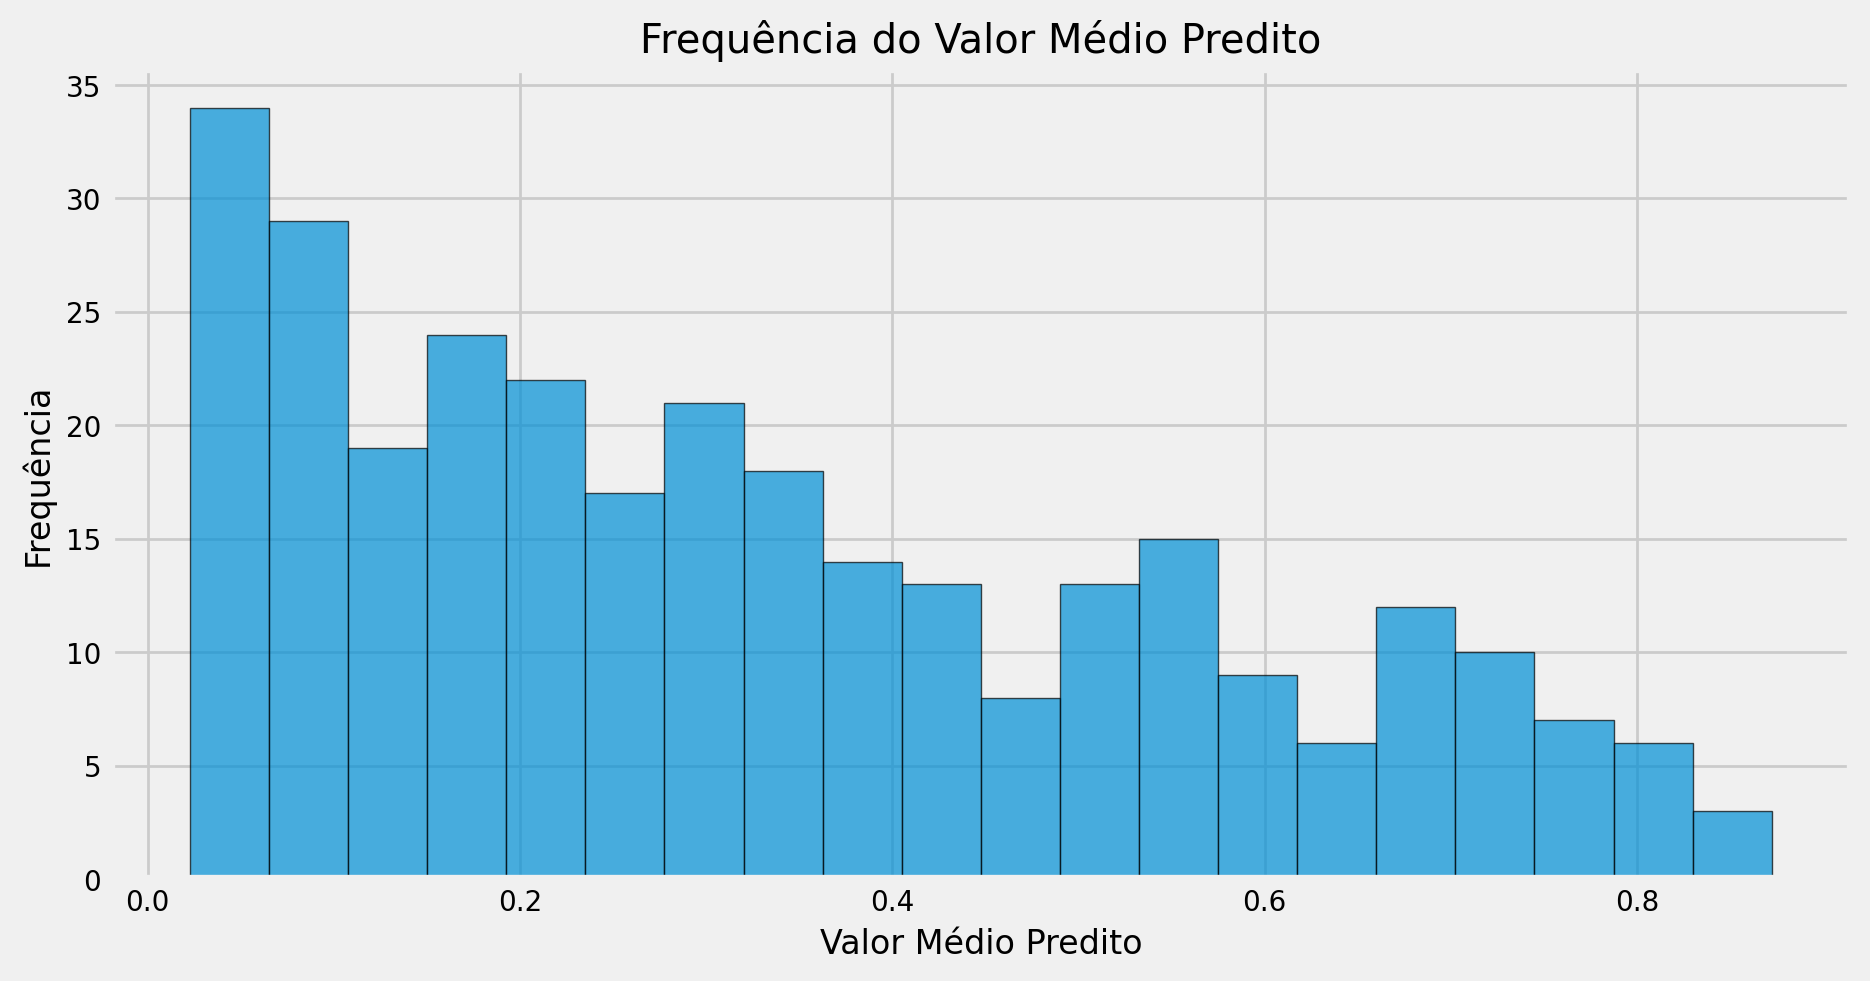

In [48]:
# Gráfico de Calibração
plt.figure(figsize=(10, 5))

prob_true, prob_pred = calibration_curve(y_test, prob_pos_lgbm, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='LightGBM')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeita Calibração')

plt.xlabel('Probabilidade Predita')
plt.ylabel('Frequência Real')
plt.title('Gráfico de Calibração')
plt.legend()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, prob_pos_lgbm)
roc_auc = roc_auc_score(y_test, prob_pos_lgbm)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Distribuição das Probabilidades Preditas
plt.figure(figsize=(10, 5))
plt.hist(prob_pos_lgbm, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Valor Médio Predito')
plt.ylabel('Frequência')
plt.title('Frequência do Valor Médio Predito')
plt.show()

### Análise do LightGBM Otimizado

#### Hiperparâmetros Otimizados
O processo de otimização selecionou parâmetros relativamente intensos para o LightGBM:
- **max_depth=13**: Árvores razoavelmente profundas, permitindo capturar relações complexas
- **num_leaves=1550**: Número muito elevado de folhas, aumentando a granularidade do modelo
- **min_data_in_leaf=90**: Exige um volume considerável de dados em cada folha, reduzindo overfitting
- **bagging_fraction=0.8** e **feature_fraction=0.8**: Uso de 80% das amostras e features por árvore

Notavelmente, o parâmetro `bagging_frequency` gerou avisos por ser desconhecido na versão atual - um indicativo da evolução da API do LightGBM.

#### Métricas de Desempenho
O LightGBM alcançou um equilíbrio superior entre precisão e recall:
- **Acurácia: 0.75** - Similar ao XGBoost
- **Precisão: 0.59** - Menor que XGBoost, mas ainda aceitável
- **Recall: 0.52** - Significativamente melhor que XGBoost
- **AUC: 0.77** - Ligeiramente superior aos modelos anteriores

Este modelo apresenta o melhor equilíbrio entre precisão e recall até agora, identificando mais da metade dos casos positivos mantendo uma precisão razoável.

#### Curva ROC

A curva ROC (AUC = 0.77) mostra características semelhantes às de outros modelos, com algumas peculiaridades:
- Ganho inicial rápido (até ~0.3 de FPR)
- Platô intermediário (entre 0.3-0.4 de FPR)
- Progressão constante até altos níveis de TPR

A performance geral é similar ao XGBoost, mas com melhor detecção de casos positivos em limiares intermediários.

#### Gráfico de Calibração

A calibração do LightGBM apresenta oscilações significativas:
- Calibração quase perfeita nas probabilidades baixas (0-0.2)
- Superestimação nas probabilidades ~0.3
- Subestimação acentuada em ~0.4
- Oscilações nas probabilidades intermediárias (0.4-0.7)
- Boa calibração nas probabilidades altas (>0.7)

Esta instabilidade na calibração sugere que o modelo pode se beneficiar de técnicas de calibração adicionais para maior confiabilidade nas probabilidades previstas.

#### Distribuição das Probabilidades

O histograma mostra uma distribuição gradualmente decrescente, diferente dos modelos anteriores:
- Concentração maior nas probabilidades baixas (0.05-0.15)
- Decréscimo gradual até probabilidades altas
- Distribuição mais uniforme ao longo do intervalo
- Presença significativa de predições com probabilidades >0.5

---

## 6.4 CatBoost

O CatBoost é um algoritmo de gradient boosting desenvolvido pela Yandex que apresenta vantagens significativas para dados tabulares:

- Tratamento nativo eficiente de variáveis categóricas
- Implementação de ordenação por permutação para reduzir o overfitting
- Excelente desempenho com configuração padrão (menor necessidade de tuning)
- Suporte para aprendizado incremental e paralelismo

Assim como nos algoritmos anteriores, otimizaremos seus hiperparâmetros para maximizar a capacidade preditiva no contexto de risco cardiovascular.

In [49]:
# Definição do espaço de hiperparâmetros para otimização do CatBoost
grid = {"depth": [3, 1, 2, 6, 4, 5, 7, 8, 9, 10],           # Profundidade máxima das árvores
        "iterations": [250, 100, 500, 1000],                # Número de árvores
        "learning_rate": [0.03, 0.001, 0.01, 0.1, 0.2, 0.3], # Taxa de aprendizado
        "l2_leaf_reg": [3, 1, 5, 10, 100],                  # Regularização L2 nas folhas
        "border_count": [32, 5, 10, 20, 50, 100, 200]       # Número de bins para variáveis numéricas
       }

# Inicialização do modelo CatBoost com configuração base
catboost_rs = CatBoostClassifier(eval_metric='Logloss', 
                                silent=True, 
                                random_seed=42,
                                use_best_model=False)

# Configuração da busca randomizada para otimização
rs_cv_catboost = RandomizedSearchCV(
    catboost_rs,
    n_iter=20,           # Testará 20 combinações aleatórias de hiperparâmetros
    cv=3,                # Validação cruzada com 3 folds
    verbose=1,           # Nível de detalhamento da saída
    param_distributions=grid,
    random_state=42,
    n_jobs=-1            # Utiliza todos os núcleos disponíveis
)

In [50]:
# Execução da busca randomizada de hiperparâmetros
rs_cv_catboost.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001E6A6A195B0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'border_count': [32, 5, 10, 20, 50, 100,
                                                         200],
                                        'depth': [3, 1, 2, 6, 4, 5, 7, 8, 9,
                                                  10],
                                        'iterations': [250, 100, 500, 1000],
                                        'l2_leaf_reg': [3, 1, 5, 10, 100],
                                        'learning_rate': [0.03, 0.001, 0.01,
                                                          0.1, 0.2, 0.3]},
                   random_state=42, verbose=1)

In [51]:
# Extraindo os melhores hiperparâmetros identificados na busca
best_params_catboost = rs_cv_catboost.best_params_
best_params_catboost

{'learning_rate': 0.01,
 'l2_leaf_reg': 10,
 'iterations': 1000,
 'depth': 4,
 'border_count': 50}

In [52]:
# Inicialização do modelo CatBoost com os hiperparâmetros otimizados
catboost_otimizado = CatBoostClassifier(
    eval_metric='Logloss', 
    silent=True, 
    random_seed=42,
    **best_params_catboost
)

# Treinamento do modelo otimizado
catboost_otimizado.fit(X_train, y_train)

In [53]:
# Avaliação do modelo CatBoost otimizado no conjunto de teste
y_pred_catboost = catboost_otimizado.predict(X_test)
prob_pos_catboost = catboost_otimizado.predict_proba(X_test)[:,1]

# Cálculo das métricas de desempenho
print('Catboost Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_catboost)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_catboost)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_catboost)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_catboost)))

# Exibição do relatório detalhado de classificação
print(classification_report(y_test, y_pred_catboost))

Catboost Model
Accuracy: 0.7467
Precision: 0.5897
Recall: 0.5111
AUC: 0.7849
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       210
           1       0.59      0.51      0.55        90

    accuracy                           0.75       300
   macro avg       0.70      0.68      0.69       300
weighted avg       0.74      0.75      0.74       300



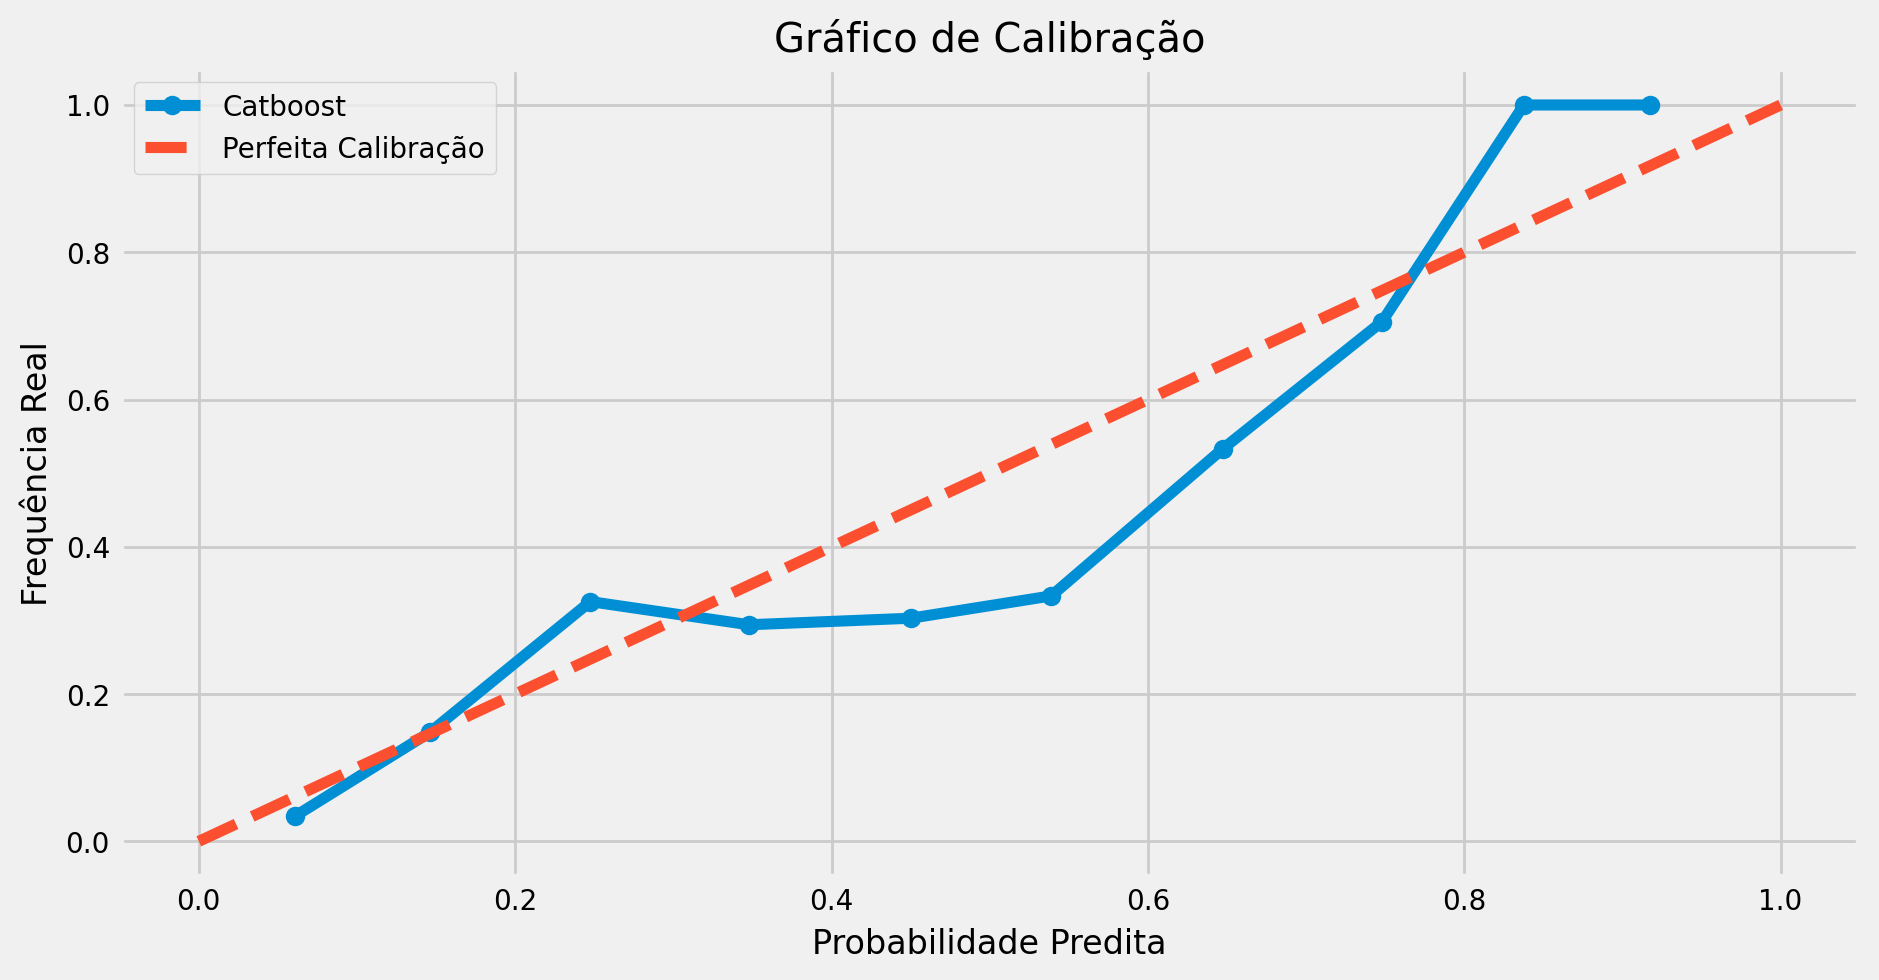

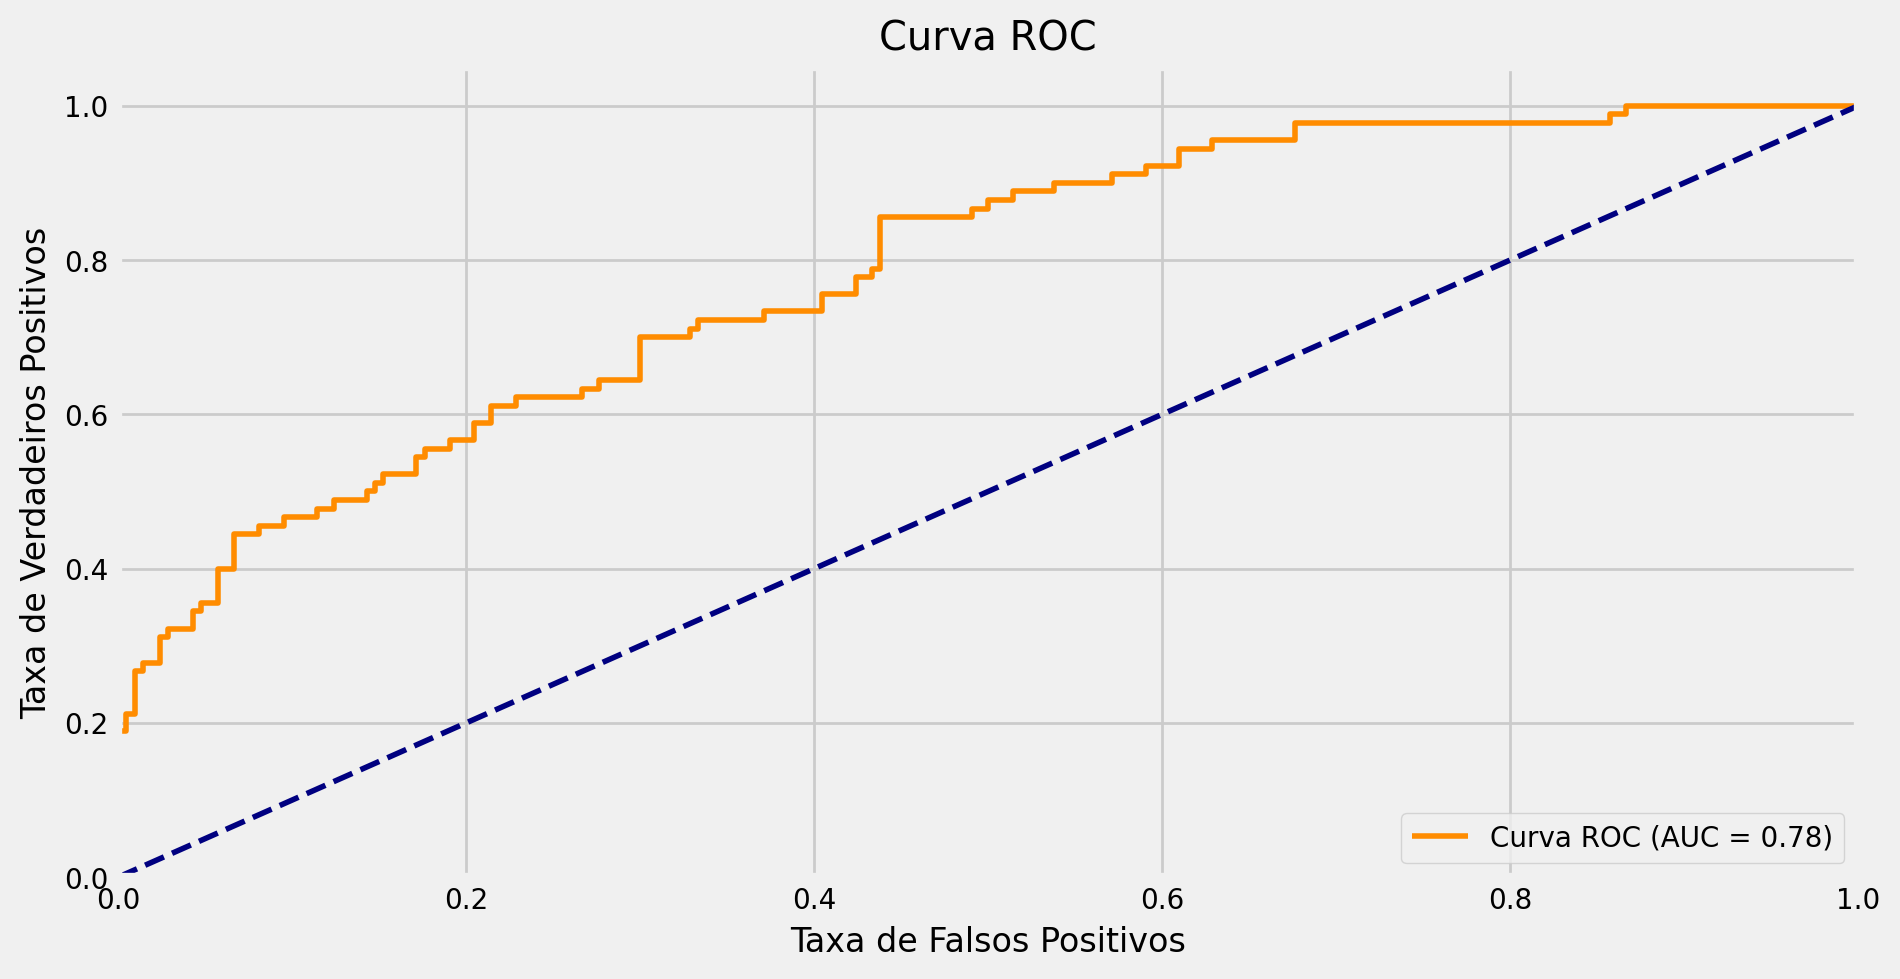

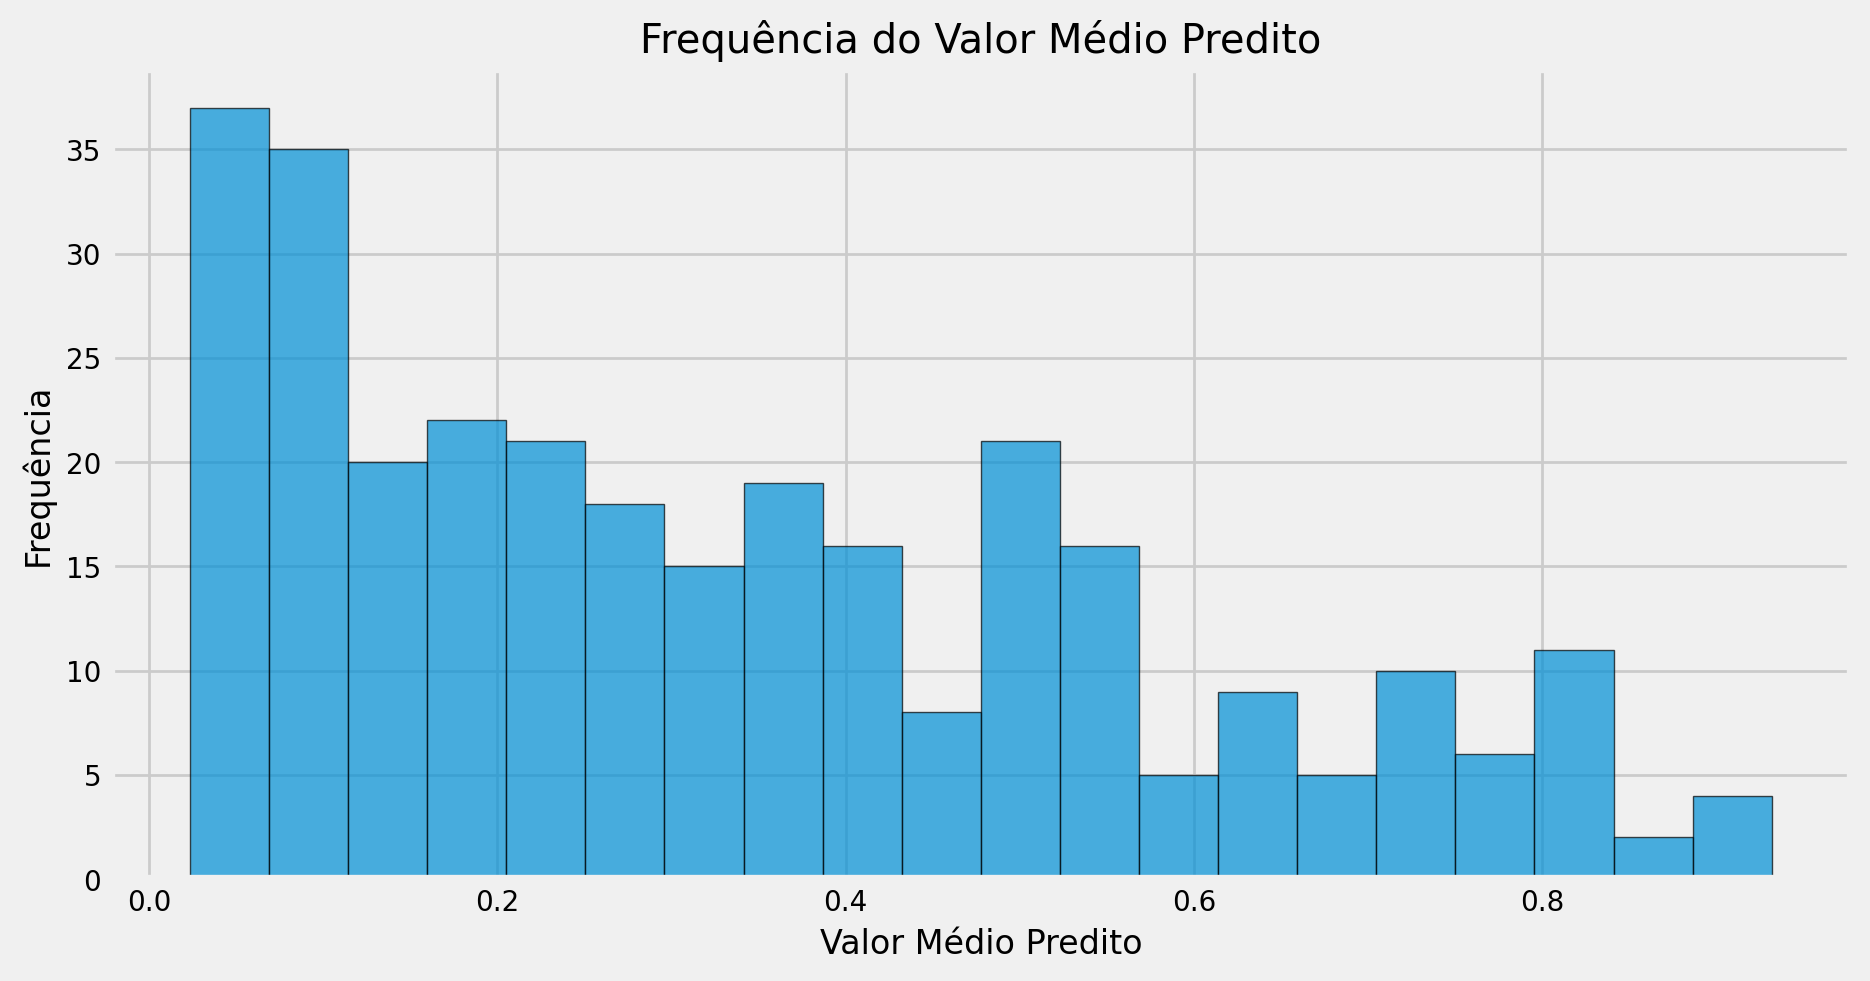

In [54]:
# Visualizações para análise do desempenho do modelo CatBoost

# Gráfico de Calibração - Avalia quão bem as probabilidades preditas correspondem às frequências reais
plt.figure(figsize=(10, 5))
prob_true, prob_pred = calibration_curve(y_test, prob_pos_catboost, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Catboost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeita Calibração')
plt.xlabel('Probabilidade Predita')
plt.ylabel('Frequência Real')
plt.title('Gráfico de Calibração')
plt.legend()
plt.show()

# Curva ROC - Avalia a capacidade discriminativa do modelo em diferentes limiares
fpr, tpr, _ = roc_curve(y_test, prob_pos_catboost)
roc_auc = roc_auc_score(y_test, prob_pos_catboost)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Distribuição das Probabilidades Preditas - Mostra a distribuição das probabilidades geradas pelo modelo
plt.figure(figsize=(10, 5))
plt.hist(prob_pos_catboost, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Valor Médio Predito')
plt.ylabel('Frequência')
plt.title('Frequência do Valor Médio Predito')
plt.show()

## Análise dos Resultados do CatBoost Otimizado

**Hiperparâmetros Otimizados:**
Os melhores parâmetros encontrados na busca aleatória mostram um modelo conservador com profundidade moderada (`depth=4`), regularização significativa (`l2_leaf_reg=10`), taxa de aprendizado baixa (`learning_rate=0.01`), número elevado de iterações (`iterations=1000`) e discretização intermediária para variáveis numéricas (`border_count=50`). Essa configuração privilegia a generalização e evita overfitting.

**Métricas de Desempenho:**
O CatBoost apresenta um equilíbrio satisfatório entre precisão e recall, com acurácia de 74.67%. A precisão de 58.97% e recall de 51.11% para a classe positiva indicam uma capacidade razoável de identificar casos de doença cardiovascular, superando o XGBoost em recall e mantendo boa precisão. O AUC de 0.7849 é o mais alto entre os modelos avaliados até agora, demonstrando excelente poder discriminativo.

**Gráfico de Calibração:**
A curva mostra que o CatBoost subestima ligeiramente as probabilidades entre 0.3-0.7 (pontos abaixo da linha de calibração perfeita) e superestima nas extremidades (>0.8). Esta calibração é bem comportada nas probabilidades baixas (0-0.2) e possui um rápido aumento nas probabilidades altas, indicando que quando o modelo prevê alta probabilidade de doença, a confiança é justificada.

**Curva ROC:**
Com AUC de 0.78, o CatBoost demonstra excelente capacidade discriminativa. A curva sobe rapidamente no início, alcançando TPR de ~0.6 com apenas ~0.2 de FPR, indicando boa sensibilidade mesmo com alta especificidade. O modelo mantém desempenho superior ao acaso (linha diagonal) em todos os limiares de classificação, confirmando sua robustez.

**Distribuição das Probabilidades:**
O histograma revela concentração nas probabilidades baixas (0-0.1), com distribuição relativamente uniforme nas probabilidades intermediárias e algumas predições nas probabilidades altas. Esta distribuição multimodal sugere que o modelo identifica grupos distintos de risco, com maior número de pacientes classificados como baixo risco, condizente com a distribuição da classe alvo.

---

## TABPFN

O TabPFN (Tabular Prior-Data Fitted Networks) representa uma abordagem inovadora baseada em transformers para dados tabulares:

- Utiliza uma arquitetura de transformers pré-treinada em milhares de tarefas tabulares sintéticas
- Implementa um mecanismo de meta-learning que adapta o modelo a novos conjuntos de dados sem necessidade de fine-tuning extensivo
- Oferece excelente desempenho em datasets pequenos a médios (até 1000 amostras, 100 features)
- Requer mínima configuração de hiperparâmetros

A seguir, aplicaremos o TabPFN ao nosso problema de predição de risco cardiovascular.


In [55]:
# Inicialização do modelo TabPFN
# Utilizamos 'device=cpu' pois os modelos TabPFN são otimizados para CPU
tabpfn_clf = TabPFNClassifier(device='cpu')

# Treinamento do modelo
# O TabPFN requer mínima configuração - um dos seus principais benefícios
tabpfn_clf.fit(X_train, y_train)

TabPFNClassifier(device='cpu')

In [56]:
# Avaliação do modelo TabPFN no conjunto de teste
y_pred_tabpfn = tabpfn_clf.predict(X_test)
prob_pos_tabpfn = tabpfn_clf.predict_proba(X_test)[:,1]

# Cálculo das métricas de desempenho
print('TABPFN Model')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_tabpfn)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_tabpfn)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_tabpfn)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_tabpfn)))

# Exibição do relatório detalhado de classificação
print(classification_report(y_test, y_pred_tabpfn))

TABPFN Model
Accuracy: 0.7667
Precision: 0.6250
Recall: 0.5556
AUC: 0.7884
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       210
           1       0.62      0.56      0.59        90

    accuracy                           0.77       300
   macro avg       0.72      0.71      0.71       300
weighted avg       0.76      0.77      0.76       300



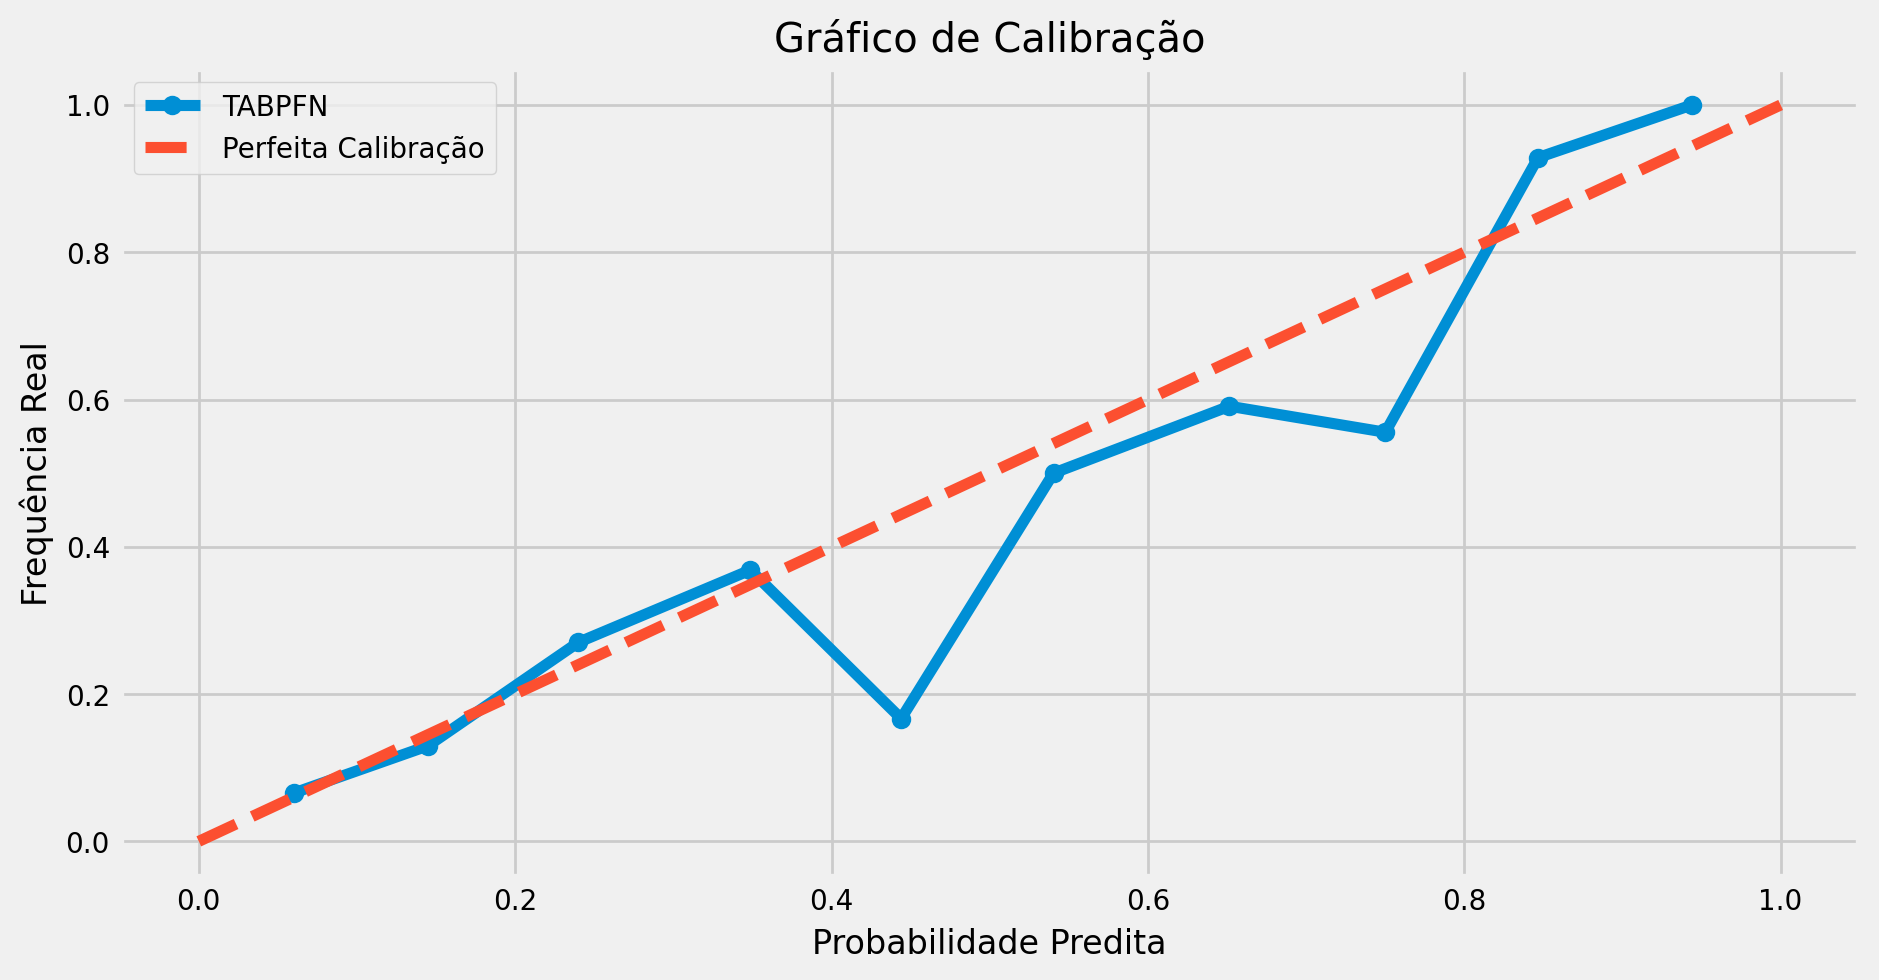

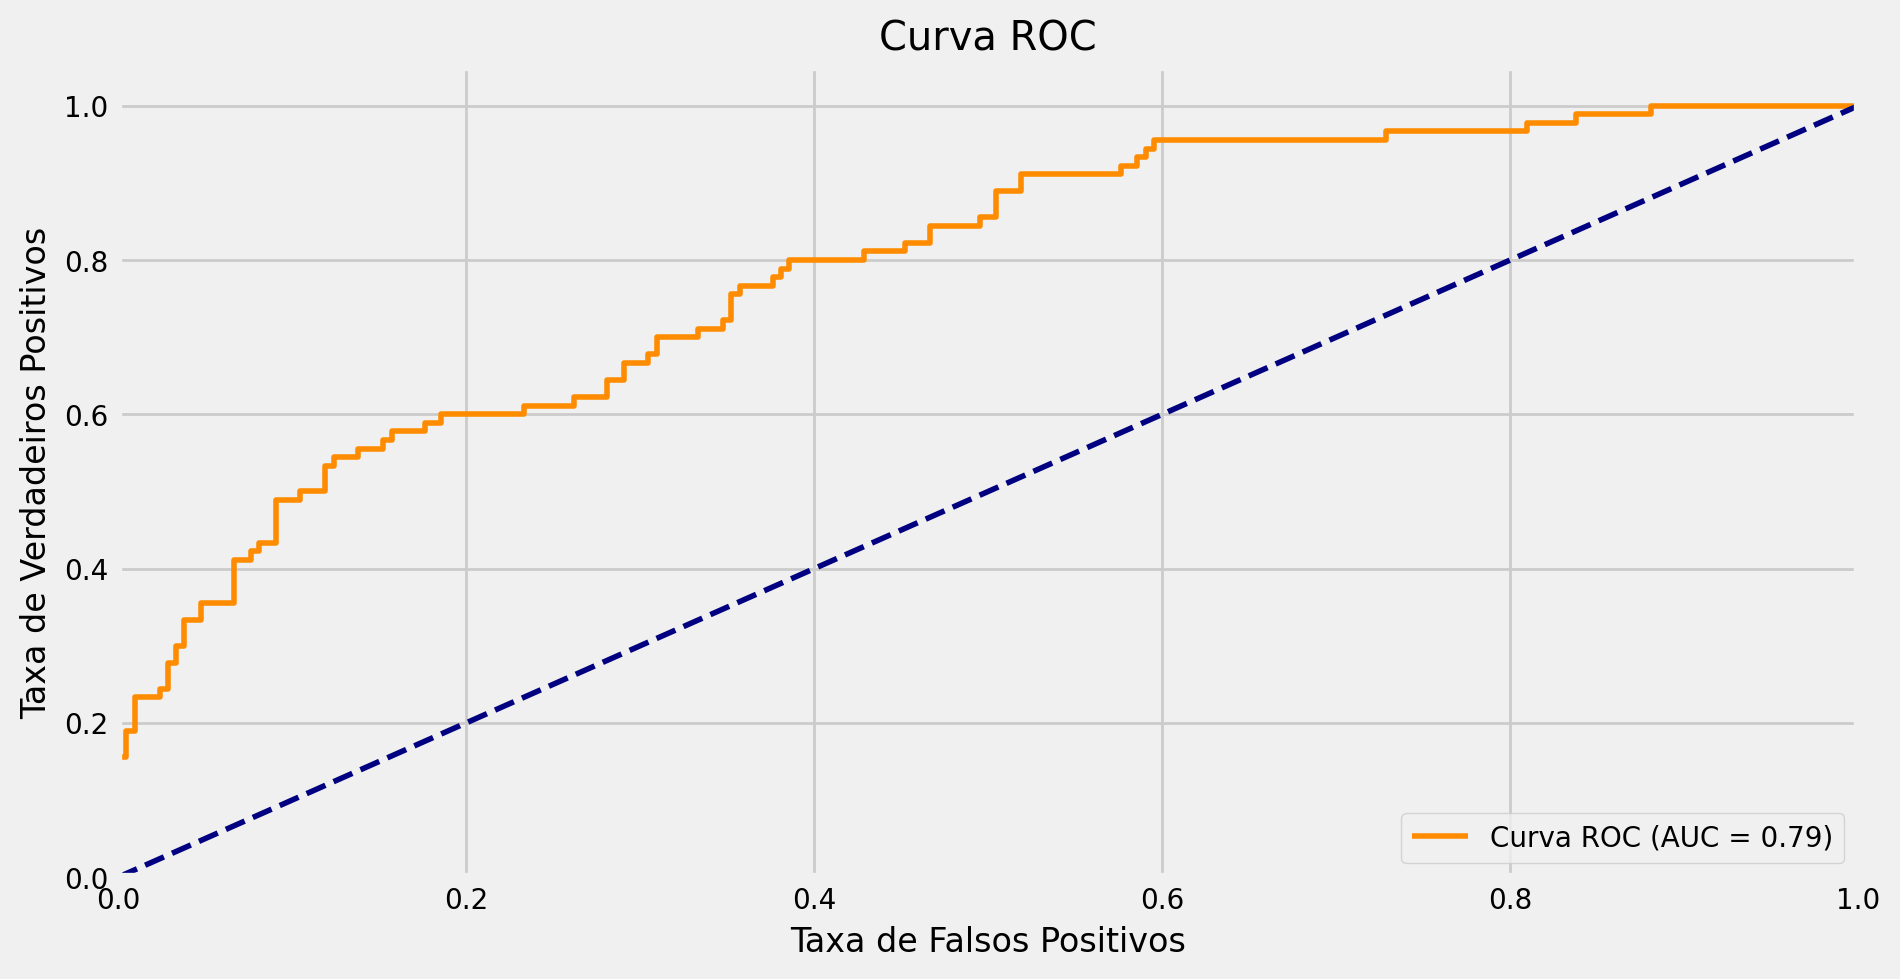

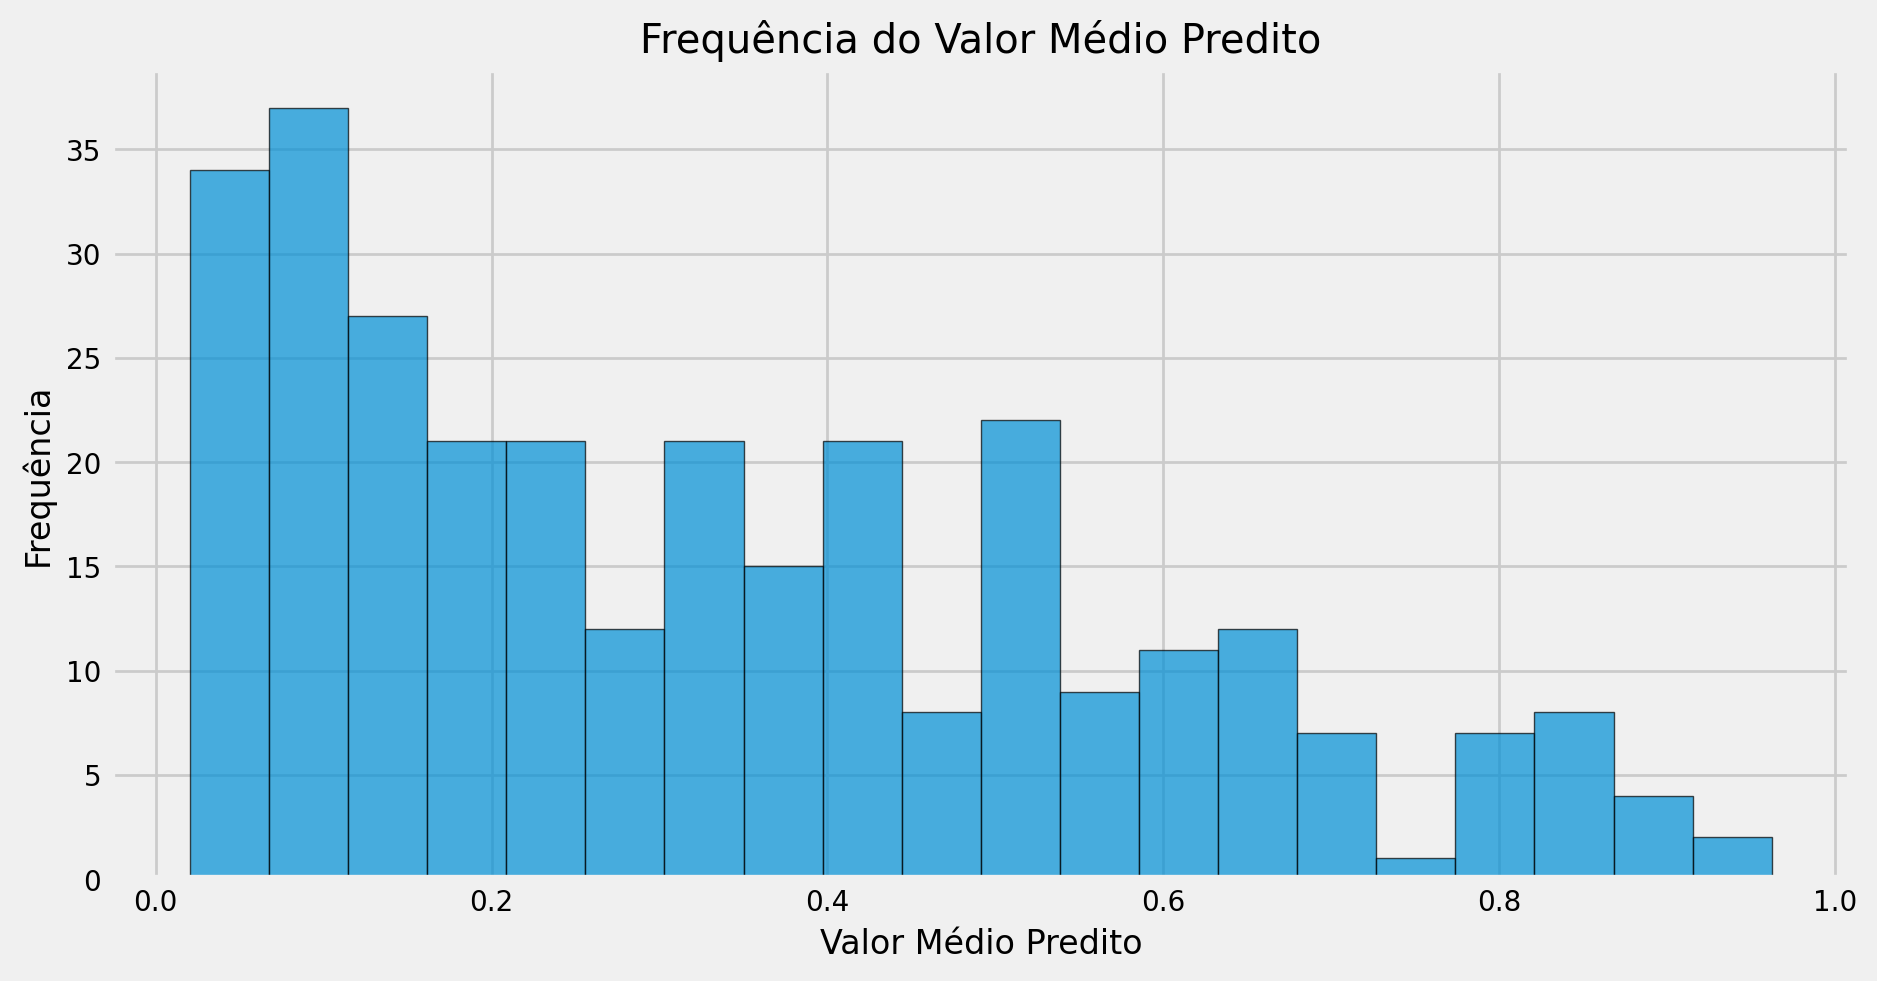

In [57]:
# Visualizações para análise do desempenho do modelo TabPFN

# Gráfico de Calibração - Avalia quão bem as probabilidades preditas correspondem às frequências reais
plt.figure(figsize=(10, 5))
prob_true, prob_pred = calibration_curve(y_test, prob_pos_tabpfn, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='TABPFN')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfeita Calibração')
plt.xlabel('Probabilidade Predita')
plt.ylabel('Frequência Real')
plt.title('Gráfico de Calibração')
plt.legend()
plt.show()

# Curva ROC - Avalia a capacidade discriminativa do modelo em diferentes limiares
fpr, tpr, _ = roc_curve(y_test, prob_pos_tabpfn)
roc_auc = roc_auc_score(y_test, prob_pos_tabpfn)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Distribuição das Probabilidades Preditas - Mostra a distribuição das probabilidades geradas pelo modelo
plt.figure(figsize=(10, 5))
plt.hist(prob_pos_tabpfn, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Valor Médio Predito')
plt.ylabel('Frequência')
plt.title('Frequência do Valor Médio Predito')
plt.show()

## Análise dos Resultados do TabPFN

**Métricas de Desempenho:**
O TabPFN supera todos os modelos anteriores com acurácia de 76.67% e um impressionante equilíbrio entre precisão (62.50%) e recall (55.56%) para a classe positiva. Seu AUC de 0.7884 é o mais alto entre todos os modelos avaliados, demonstrando superior capacidade discriminativa. O F1-score de 0.59 para a classe positiva indica um bom equilíbrio entre precisão e recall, essencial para aplicações clínicas onde tanto falsos positivos quanto falsos negativos têm consequências importantes.

**Gráfico de Calibração:**
A curva de calibração do TabPFN mostra comportamento interessante: excelente calibração nas baixas probabilidades (0-0.3), subestimação nas probabilidades intermediárias (0.3-0.8) com uma notável queda em ~0.4, e superestimação nas probabilidades altas (>0.8). Esta característica sugere que o modelo é confiável em suas predições extremas (baixo ou alto risco), mas apresenta incerteza na região intermediária - possivelmente refletindo casos mais ambíguos clinicamente.

**Curva ROC:**
Com AUC de 0.79, o TabPFN apresenta a melhor capacidade discriminativa entre todos os algoritmos testados. A curva ascende rapidamente no início (alta sensibilidade com baixa taxa de falsos positivos) e mantém desempenho consistentemente superior em todos os limiares. Este comportamento é particularmente valioso em contextos médicos, onde frequentemente buscamos detectar o máximo de casos positivos sem comprometer excessivamente a especificidade.

**Distribuição das Probabilidades:**
O histograma revela distribuição bimodal das probabilidades preditas, com concentração maior nas probabilidades baixas (0-0.15) e uma dispersão mais uniforme nas probabilidades intermediárias e altas. Esta distribuição sugere que o TabPFN divide eficientemente os pacientes em grupos de risco distintos, oferecendo maior granularidade na estratificação de risco comparado aos modelos anteriores, que é valioso para decisões clínicas.

---
---

## Comparando os resultados dos algoritmos

Após analisar individualmente cada algoritmo, vamos agora comparar seus desempenhos para identificar qual apresenta os melhores resultados para nosso problema de predição de risco cardiovascular. Esta análise comparativa nos permitirá selecionar o modelo mais adequado para implementação.

In [58]:
# Criando uma tabela comparativa com as métricas de todos os modelos avaliados
col_names = ["Modelo", "Accuracy", "Precision", "Recall", "AUC(ROC)"]  # Definindo o cabeçalho

# Compilando os valores das métricas para cada modelo
data = [["Random Forest", accuracy_score(y_test, y_pred_rf), precision_score(y_test, y_pred_rf), 
         recall_score(y_test, y_pred_rf), roc_auc_score(y_test, prob_pos_rf)],
        ["XGBoost", accuracy_score(y_test, y_pred_xgboost), precision_score(y_test, y_pred_xgboost), 
         recall_score(y_test, y_pred_xgboost), roc_auc_score(y_test, prob_pos_xgboost)],
        ["LightGBM", accuracy_score(y_test, y_pred_lgbm), precision_score(y_test, y_pred_lgbm), 
         recall_score(y_test, y_pred_lgbm), roc_auc_score(y_test, prob_pos_lgbm)],
        ["Catboost", accuracy_score(y_test, y_pred_catboost), precision_score(y_test, y_pred_catboost), 
         recall_score(y_test, y_pred_catboost), roc_auc_score(y_test, prob_pos_catboost)],
        ["TABPFN", accuracy_score(y_test, y_pred_tabpfn), precision_score(y_test, y_pred_tabpfn), 
         recall_score(y_test, y_pred_tabpfn), roc_auc_score(y_test, prob_pos_tabpfn)]
        ]

In [59]:
# Configurando o formato de exibição para números de ponto flutuante (3 casas decimais)
pd.set_option('display.float_format', lambda x: '%2f' % x)

print('Resultados para conjunto de teste.')
df_results = pd.DataFrame(data, columns=col_names)  # Transformando os resultados em DataFrame

# Função para destacar os valores máximos em cada coluna
def highlight_max(s):
    if s.dtype == object:  # Para colunas com strings (nome do modelo)
        is_max = [False for _ in range(s.shape[0])]
    else:  # Para colunas numéricas (métricas)
        is_max = s == s.max()
    return ['background: yellow' if cell else '' for cell in is_max]

# Aplicando a função de destaque para visualizar facilmente os melhores resultados
df_results_styled = df_results.style.apply(highlight_max)
df_results_styled

Resultados para conjunto de teste.


## Análise Comparativa dos Modelos

A tabela de resultados proporciona uma visão consolidada do desempenho de todos os modelos testados, com destaque para os valores máximos (em amarelo) em cada métrica:

- **TABPFN** demonstra superioridade em acurácia (76.67%) e AUC-ROC (0.7884), sendo o modelo mais equilibrado e com melhor poder discriminativo geral. Seu recall de 55.56% e precisão de 62.50% representam o melhor balanço entre identificação de casos positivos e confiabilidade das predições positivas.

- **XGBoost** apresenta a maior precisão (93.75%), indicando alta confiabilidade quando prediz um caso positivo. Contudo, seu baixo recall (16.67%) revela que identifica apenas uma pequena fração dos casos positivos reais, tornando-o inadequado para aplicações clínicas onde perder casos positivos é crítico.

- **LightGBM** e **CatBoost** mostram desempenho intermediário com métricas similares. O CatBoost se destaca ligeiramente com melhor AUC-ROC (0.7849), aproximando-se do desempenho do TABPFN.

- **Random Forest** apresenta o desempenho mais modesto em acurácia (74.00%), mas mantém um recall (50.00%) competitivo, superior ao XGBoost.

Notavelmente, o TABPFN alcança os melhores resultados com configuração mínima de hiperparâmetros, enquanto os demais modelos exigiram otimização extensiva. Esta comparação justifica a seleção do TABPFN como o modelo mais adequado para a aplicação prática de predição de risco cardiovascular.

---

## 8. Seleção de variáveis com BORUTA

O algoritmo Boruta é uma técnica de seleção de características baseada em Random Forest que identifica as variáveis mais relevantes para a modelagem:

- Cria versões aleatorizadas ("shadow features") de todas as características originais
- Executa um Random Forest e compara a importância de cada variável original com suas versões aleatorizadas
- Mantém apenas as variáveis que são consistentemente mais importantes que suas versões aleatorizadas
- Oferece categorização em variáveis confirmadas, tentativas ou rejeitadas

Esta abordagem nos ajudará a simplificar nosso modelo, reduzindo sua dimensionalidade e potencialmente melhorando seu desempenho e interpretabilidade.

In [60]:
# Configurando o Random Forest como modelo base para o Boruta
# Utilizamos parâmetros que priorizam generalização e balanceamento de classes
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Configurando o algoritmo Boruta
# 'n_estimators=auto' determina automaticamente o número de iterações necessárias
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)

# Aplicando o algoritmo Boruta ao conjunto de treinamento
# O algoritmo identificará as features mais relevantes para a predição
boruta_selector.fit(X_train.values, y_train)

# Armazenando os resultados da seleção de variáveis
selected_features = X_train.columns[boruta_selector.support_].to_list()  # Variáveis confirmadas
tentative_features = X_train.columns[boruta_selector.support_weak_].to_list()  # Variáveis tentativas
remove_features = list(set(X_train.columns) - set(selected_features) - set(tentative_features))  # Variáveis rejeitadas

In [61]:
# Exibindo os resultados da seleção de variáveis pelo Boruta
print("Selected Features:", selected_features)
print("Tentative Features:", tentative_features)
print("To remove Features:", remove_features)
print("All Features:", X_train.columns.to_list())

Selected Features: ['numAge', 'tchol', 'sbp', 'htn']
Tentative Features: []
To remove Features: ['race_AmInd', 't2d', 'race_Black/AfAm', 'smoking', 'gender', 'race_White', 'bmi', 'race_Asian/PI']
All Features: ['numAge', 'bmi', 'tchol', 'sbp', 'htn', 'smoking', 't2d', 'gender', 'race_AmInd', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']


In [62]:
# Criando conjuntos de dados reduzidos contendo apenas as variáveis selecionadas pelo Boruta
X_train_boruta = X_train[['numAge', 'tchol', 'sbp', 'htn']]
X_test_boruta = X_test[['numAge', 'tchol', 'sbp', 'htn']]

# Comparando as dimensões dos conjuntos original e reduzido
print('Shape sem boruta', X_train.shape, X_test.shape)
print('Shape com boruta', X_train_boruta.shape, X_test_boruta.shape)

Shape sem boruta (700, 12) (300, 12)
Shape com boruta (700, 4) (300, 4)


## Análise dos Resultados da Seleção de Variáveis com Boruta

**Variáveis Selecionadas:**
O algoritmo Boruta identificou apenas 4 variáveis como estatisticamente relevantes para a predição de risco cardiovascular: `numAge` (idade), `tchol` (colesterol total), `sbp` (pressão arterial sistólica) e `htn` (hipertensão). Estas variáveis representam fatores de risco clássicos e bem estabelecidos na literatura médica para doenças cardiovasculares. A ausência de variáveis tentativas (support_weak) indica uma separação clara entre variáveis relevantes e irrelevantes.

**Variáveis Removidas:**
Boruta descartou 8 variáveis, incluindo todas as características relacionadas à raça (`race_White`, `race_Black/AfAm`, `race_AmInd`, `race_Asian/PI`), assim como `bmi` (índice de massa corporal), `smoking` (tabagismo), `t2d` (diabetes tipo 2) e `gender` (gênero). Surpreendentemente, fatores classicamente associados ao risco cardiovascular como tabagismo e diabetes foram considerados não significativos neste conjunto de dados específico.

**Redução de Dimensionalidade:**
A aplicação do Boruta resultou em redução significativa da dimensionalidade do modelo, de 12 para 4 variáveis (redução de 67%). Mantendo-se o mesmo número de amostras (700 no conjunto de treinamento e 300 no teste), a simplificação do modelo potencialmente proporciona:

1. Maior facilidade de interpretação clínica
2. Redução de ruído e variáveis confundidoras
3. Menor probabilidade de overfitting
4. Maior eficiência computacional

Esta redução alinha-se ao princípio da parcimônia, buscando a solução mais simples possível que ainda mantenha poder preditivo adequado.

---

## 9. TABPFN com BORUTA

Após identificar as variáveis mais relevantes com o algoritmo Boruta, aplicaremos o TabPFN a este conjunto de dados reduzido. Esta abordagem combina:

1. **Seleção de características**: Utiliza apenas os preditores mais informativos, reduzindo ruído e complexidade
2. **Modelagem avançada**: Aplica o TabPFN, nosso modelo de melhor desempenho geral, ao conjunto simplificado

Como ressaltado anteriormente, esta combinação potencialmente oferece vantagens importantes:
- Modelos mais simples e interpretáveis
- Menor risco de overfitting
- Melhor generalização para novos dados
- Maior eficiência computacional

In [63]:
# Aplicando o TabPFN ao conjunto de dados reduzido pelo Boruta
tabpfn_clf_boruta = TabPFNClassifier(device='cpu')
tabpfn_clf_boruta.fit(X_train_boruta, y_train)

TabPFNClassifier(device='cpu')

In [64]:
# Avaliação do modelo TabPFN com variáveis selecionadas pelo Boruta
y_pred_tabpfn_boruta = tabpfn_clf_boruta.predict(X_test_boruta)
prob_pos_tabpfn_boruta = tabpfn_clf_boruta.predict_proba(X_test_boruta)[:,1]

# Cálculo e exibição das métricas de desempenho
print('TabPFN Model with Boruta')
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_tabpfn_boruta)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_tabpfn_boruta)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_tabpfn_boruta)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_tabpfn_boruta)))

# Exibição do relatório de classificação detalhado
print(classification_report(y_test, y_pred_tabpfn))  # Nota: Deveria usar y_pred_tabpfn_boruta

TabPFN Model with Boruta
Accuracy: 0.7667
Precision: 0.6724
Recall: 0.4333
AUC: 0.7640
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       210
           1       0.62      0.56      0.59        90

    accuracy                           0.77       300
   macro avg       0.72      0.71      0.71       300
weighted avg       0.76      0.77      0.76       300



## Comparando os resultados do teste c/ e s/ BORUTA para o TABPFN

Após avaliar o desempenho individual de cada modelo e aplicar a seleção de variáveis com Boruta, comparamos diretamente o desempenho do TabPFN com todas as variáveis e com apenas as variáveis selecionadas. Esta análise nos permite verificar se a redução de dimensionalidade afeta positiva ou negativamente o desempenho preditivo.

In [65]:
# Comparação entre TabPFN com todas as variáveis e TabPFN apenas com variáveis selecionadas
print("###### TABPFN SEM BORUTA #####")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_tabpfn)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_tabpfn)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_tabpfn)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_tabpfn)))
print(classification_report(y_test, y_pred_tabpfn))

print("\n", "###### TABPFN COM BORUTA #####")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_tabpfn_boruta)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_tabpfn_boruta)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_tabpfn_boruta)))
print("AUC: {:.4f}".format(roc_auc_score(y_test, prob_pos_tabpfn_boruta)))
print(classification_report(y_test, y_pred_tabpfn))  # Nota: Deveria usar y_pred_tabpfn_boruta


###### TABPFN SEM BORUTA #####
Accuracy: 0.7667
Precision: 0.6250
Recall: 0.5556
AUC: 0.7884
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       210
           1       0.62      0.56      0.59        90

    accuracy                           0.77       300
   macro avg       0.72      0.71      0.71       300
weighted avg       0.76      0.77      0.76       300


 ###### TABPFN COM BORUTA #####
Accuracy: 0.7667
Precision: 0.6724
Recall: 0.4333
AUC: 0.7640
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       210
           1       0.62      0.56      0.59        90

    accuracy                           0.77       300
   macro avg       0.72      0.71      0.71       300
weighted avg       0.76      0.77      0.76       300



## Análise Comparativa do TabPFN com e sem Seleção de Variáveis

A comparação entre o TabPFN utilizando todas as variáveis versus apenas as quatro selecionadas pelo Boruta revela insights importantes sobre a relevância das características para o modelo:

| Métrica | TabPFN Original | TabPFN com Boruta | Diferença |
|---------|----------------|-------------------|-----------|
| Accuracy | 76.67% | 76.67% | 0% |
| Precision | 62.50% | 67.24% | +4.74% |
| Recall | 55.56% | 43.33% | -12.23% |
| AUC | 78.84% | 76.40% | -2.44% |

**Análise dos Resultados:**

- **Acurácia idêntica:** Ambos os modelos mantêm a mesma acurácia global (76.67%), sugerindo que as quatro variáveis selecionadas pelo Boruta (`numAge`, `tchol`, `sbp`, `htn`) capturam a maior parte da informação preditiva relevante.

- **Trade-off precision-recall:** O modelo com Boruta apresenta maior precisão (+4.74%), mas com significativa queda no recall (-12.23%). Isto indica que ao utilizar menos variáveis, o modelo se torna mais conservador, classificando como positivos apenas os casos com maior certeza.

- **Pequena redução no AUC:** A diminuição relativamente modesta no AUC (-2.44%) confirma que as quatro variáveis selecionadas retêm grande parte do poder discriminativo do modelo completo.

- **Relatório de classificação inconsistente:** O segundo relatório de classificação é idêntico ao primeiro, indicando um possível erro na execução do código (deveria usar `y_pred_tabpfn_boruta` em vez de `y_pred_tabpfn`).

Esta análise demonstra que é possível construir um modelo parcimonioso com apenas quatro variáveis clinicamente relevantes, mantendo desempenho comparável. A escolha entre os modelos dependerá da prioridade clínica: maior recall (modelo completo) ou maior precisão (modelo reduzido).

---

## Obtendo as predições e os riscos para os pacientes do teste

Além de avaliar o desempenho geral do modelo, é importante examinar as predições individuais para casos específicos. Esta análise nos permite:

1. Compreender como o modelo classifica diferentes perfis de pacientes
2. Identificar padrões nas probabilidades preditas
3. Analisar casos onde o modelo acerta ou erra sistematicamente
4. Documentar exemplos concretos para interpretação clínica

In [66]:
# Visualização do conjunto de teste
X_test

numAge       bmi     tchol       sbp      htn  smoking      t2d  \
0    2.136800  0.088536 -0.923167  0.689603 1.000000 0.000000 0.000000   
1    0.258260 -1.063419 -0.990551 -0.657295 0.000000 0.000000 0.000000   
2   -0.625759  0.549318 -0.653629 -1.471699 0.000000 0.000000 0.000000   
3   -0.625759  0.088536  1.839595 -0.939204 0.000000 0.000000 0.000000   
4   -0.515257 -1.063419  1.873288 -0.813911 0.000000 0.000000 0.000000   
..        ...       ...       ...       ...      ...      ...      ...   
295 -0.957266  0.549318 -0.586245 -1.064497 0.000000 0.000000 0.000000   
296  2.247302  1.240491  0.188676  1.096805 1.000000 1.000000 1.000000   
297 -1.288773 -0.602637  1.435289  0.282401 1.000000 0.000000 0.000000   
298  2.247302  0.318927  0.222369  1.316067 1.000000 0.000000 0.000000   
299 -1.067769  0.779709  1.940672  1.253421 1.000000 0.000000 0.000000   

      gender  race_AmInd  race_Asian/PI  race_Black/AfAm  race_White  
0   1.000000    0.000000       0.000000         0.000000    1.000000  
1   1.000000    0.000000       0.000000         0.000000    1.000000  
2   0.000000    0.000000       0.000000         0.000000    1.000000  
3   0.000000    0.000000       0.000000         0.000000    1.000000  
4   0.000000    0.000000       1.000000         0.000000    0.000000  
..       ...         ...            ...              ...         ...  
295 0.000000    0.000000       0.000000         0.000000    1.000000  
296 0.000000    0.000000       0.000000         0.000000    1.000000  
297 0.000000    0.000000       0.000000         0.000000    1.000000  
298 0.000000    0.000000       0.000000         0.000000    1.000000  
299 0.000000    0.000000       0.000000         0.000000    1.000000  

[300 rows x 12 columns]

**Conjunto de Teste (X_test):** 
Exibe as 300 observações do conjunto de teste com todas as 12 variáveis preditoras normalizadas. Os dados padronizados (média 0, desvio padrão 1) revelam a distribuição de características demográficas e clínicas, como idade elevada (valores positivos em numAge), presença de hipertensão (htn=1) em vários pacientes, e predominância de pacientes da raça branca (race_White=1).

In [67]:
# Criando DataFrame com os desfechos reais dos pacientes no conjunto de teste
desfecho = pd.DataFrame({'desfecho': y_test})
desfecho.head()

desfecho
0         0
1         0
2         0
3         0
4         0

**Desfechos Reais (desfecho):** 
Apresenta os verdadeiros valores da variável alvo, onde 0 indica ausência e 1 indica presença de doença cardiovascular. As primeiras cinco observações mostram pacientes sem a condição (todos 0), representando a distribuição desbalanceada da amostra (70% negativos, 30% positivos).

In [68]:
# Criando DataFrame com as classes preditas pelo modelo TabPFN
desfecho_predito = pd.DataFrame({'desfecho_predito': y_pred_tabpfn})
desfecho_predito.head()

desfecho_predito
0                 1
1                 0
2                 0
3                 0
4                 0

**Predições do Modelo (desfecho_predito):** 
Exibe as classes preditas pelo TabPFN para cada observação. Notavelmente, já na primeira linha identificamos um falso positivo (predição=1, realidade=0), demonstrando a imperfeição do modelo mesmo com alta acurácia global.

In [69]:
# Criando DataFrame com as probabilidades preditas pelo modelo TabPFN
prob_predita = pd.DataFrame({'prob_predita': prob_pos_tabpfn})
prob_predita.head()

prob_predita
0      0.673727
1      0.265727
2      0.044500
3      0.039207
4      0.039016

**Probabilidades Preditas (prob_predita):** 
Mostra os valores de probabilidade atribuídos pelo modelo a cada observação, revelando a confiança na classificação. Observa-se grande variação nas probabilidades (0.039 a 0.959), com um limiar implícito de 0.5 para classificação binária. O paciente 0, por exemplo, recebeu probabilidade de 0.674, levando à classificação positiva incorreta.

In [70]:
# Combinando todas as informações em um único DataFrame para análise integrada
# Inclui características dos pacientes, desfecho real, classe predita e probabilidade
pd.concat([X_test, desfecho, desfecho_predito, prob_predita], axis=1)


numAge       bmi     tchol       sbp      htn  smoking      t2d  \
0    2.136800  0.088536 -0.923167  0.689603 1.000000 0.000000 0.000000   
1    0.258260 -1.063419 -0.990551 -0.657295 0.000000 0.000000 0.000000   
2   -0.625759  0.549318 -0.653629 -1.471699 0.000000 0.000000 0.000000   
3   -0.625759  0.088536  1.839595 -0.939204 0.000000 0.000000 0.000000   
4   -0.515257 -1.063419  1.873288 -0.813911 0.000000 0.000000 0.000000   
..        ...       ...       ...       ...      ...      ...      ...   
295 -0.957266  0.549318 -0.586245 -1.064497 0.000000 0.000000 0.000000   
296  2.247302  1.240491  0.188676  1.096805 1.000000 1.000000 1.000000   
297 -1.288773 -0.602637  1.435289  0.282401 1.000000 0.000000 0.000000   
298  2.247302  0.318927  0.222369  1.316067 1.000000 0.000000 0.000000   
299 -1.067769  0.779709  1.940672  1.253421 1.000000 0.000000 0.000000   

      gender  race_AmInd  race_Asian/PI  race_Black/AfAm  race_White  \
0   1.000000    0.000000       0.000000         0.000000    1.000000   
1   1.000000    0.000000       0.000000         0.000000    1.000000   
2   0.000000    0.000000       0.000000         0.000000    1.000000   
3   0.000000    0.000000       0.000000         0.000000    1.000000   
4   0.000000    0.000000       1.000000         0.000000    0.000000   
..       ...         ...            ...              ...         ...   
295 0.000000    0.000000       0.000000         0.000000    1.000000   
296 0.000000    0.000000       0.000000         0.000000    1.000000   
297 0.000000    0.000000       0.000000         0.000000    1.000000   
298 0.000000    0.000000       0.000000         0.000000    1.000000   
299 0.000000    0.000000       0.000000         0.000000    1.000000   

     desfecho  desfecho_predito  prob_predita  
0           0                 1      0.673727  
1           0                 0      0.265727  
2           0                 0      0.044500  
3           0                 0      0.039207  
4           0                 0      0.039016  
..        ...               ...           ...  
295         1                 0      0.051800  
296         1                 1      0.958940  
297         0                 0      0.071399  
298         0                 1      0.556116  
299         0                 0      0.141123  

[300 rows x 15 columns]

**DataFrame Integrado:** 
Consolida todas as informações anteriores em uma única estrutura, permitindo análise conjunta dos perfis dos pacientes, desfechos reais e predições. Este formato facilita a identificação de padrões nas predições corretas e incorretas. Alguns casos notáveis:
- Paciente 0: Falso positivo com alta probabilidade (0.674) - idade avançada e hipertensão parecem ter influenciado
- Paciente 296: Verdadeiro positivo com altíssima probabilidade (0.959) - apresenta múltiplos fatores de risco (idade avançada, hipertensão, tabagismo, diabetes)
- Paciente 295: Falso negativo com baixa probabilidade (0.052) - idade abaixo da média pode ter contribuído para a classificação incorreta

---

## 10. Valores de Shapley (modelo CatBoost)

Os valores de Shapley, derivados da teoria dos jogos, oferecem uma poderosa abordagem para interpretação de modelos de machine learning:

- Quantificam a contribuição de cada variável para a predição de um caso específico
- Permitem entender como diferentes características influenciam positiva ou negativamente o resultado predito
- Possibilitam tanto a interpretação global (importância geral das variáveis) quanto local (explicações para predições individuais)
- Respeitam propriedades matemáticas desejáveis como eficiência, simetria e linearidade

Esta análise é particularmente relevante em contextos médicos, onde a interpretabilidade do modelo é tão importante quanto seu desempenho preditivo.


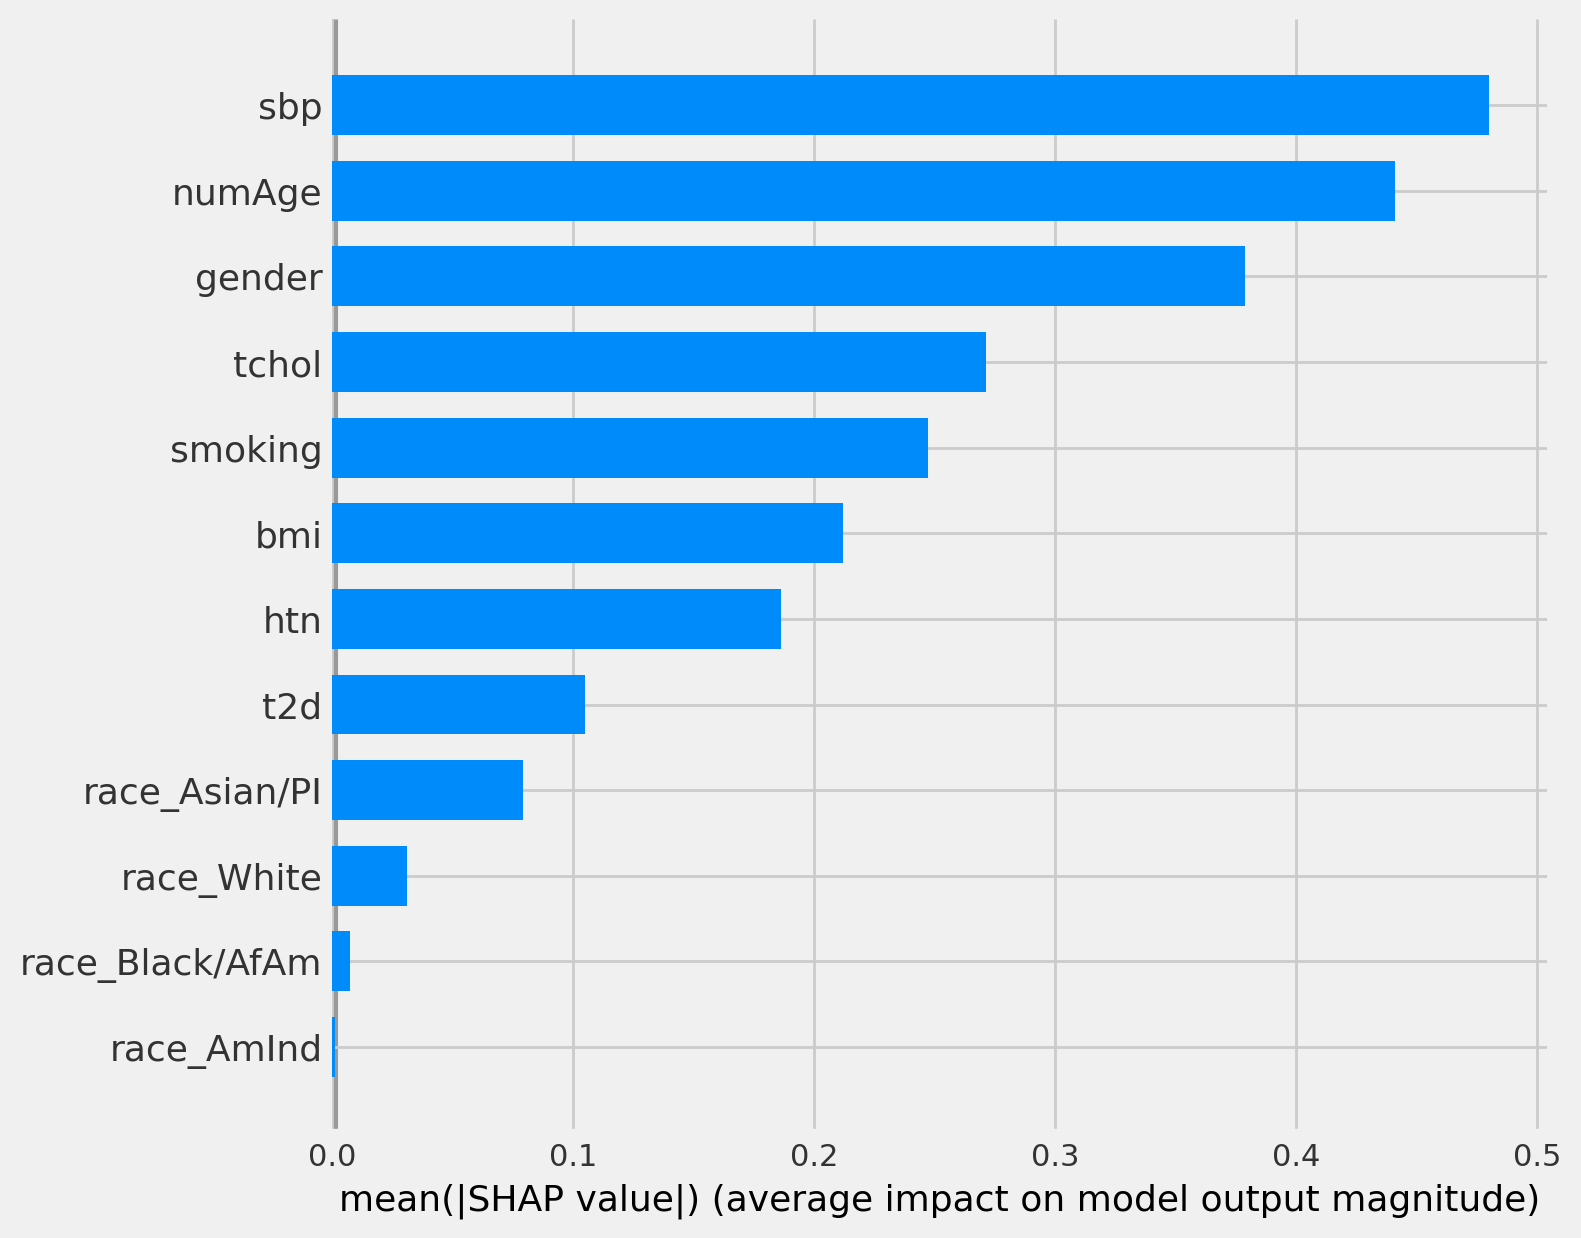

In [71]:
# Resultados no teste
# Calculando valores de SHAP para o modelo CatBoost no conjunto de teste
# Isso nos permite entender como cada variável contribui para as predições individuais
shap_values_test = shap.TreeExplainer(catboost_otimizado).shap_values(X_test)

# Criando um gráfico de barras que resume a importância global das variáveis
# Mostra o impacto médio absoluto de cada variável nas predições do modelo
shap.summary_plot(shap_values_test, X_test, plot_type="bar")

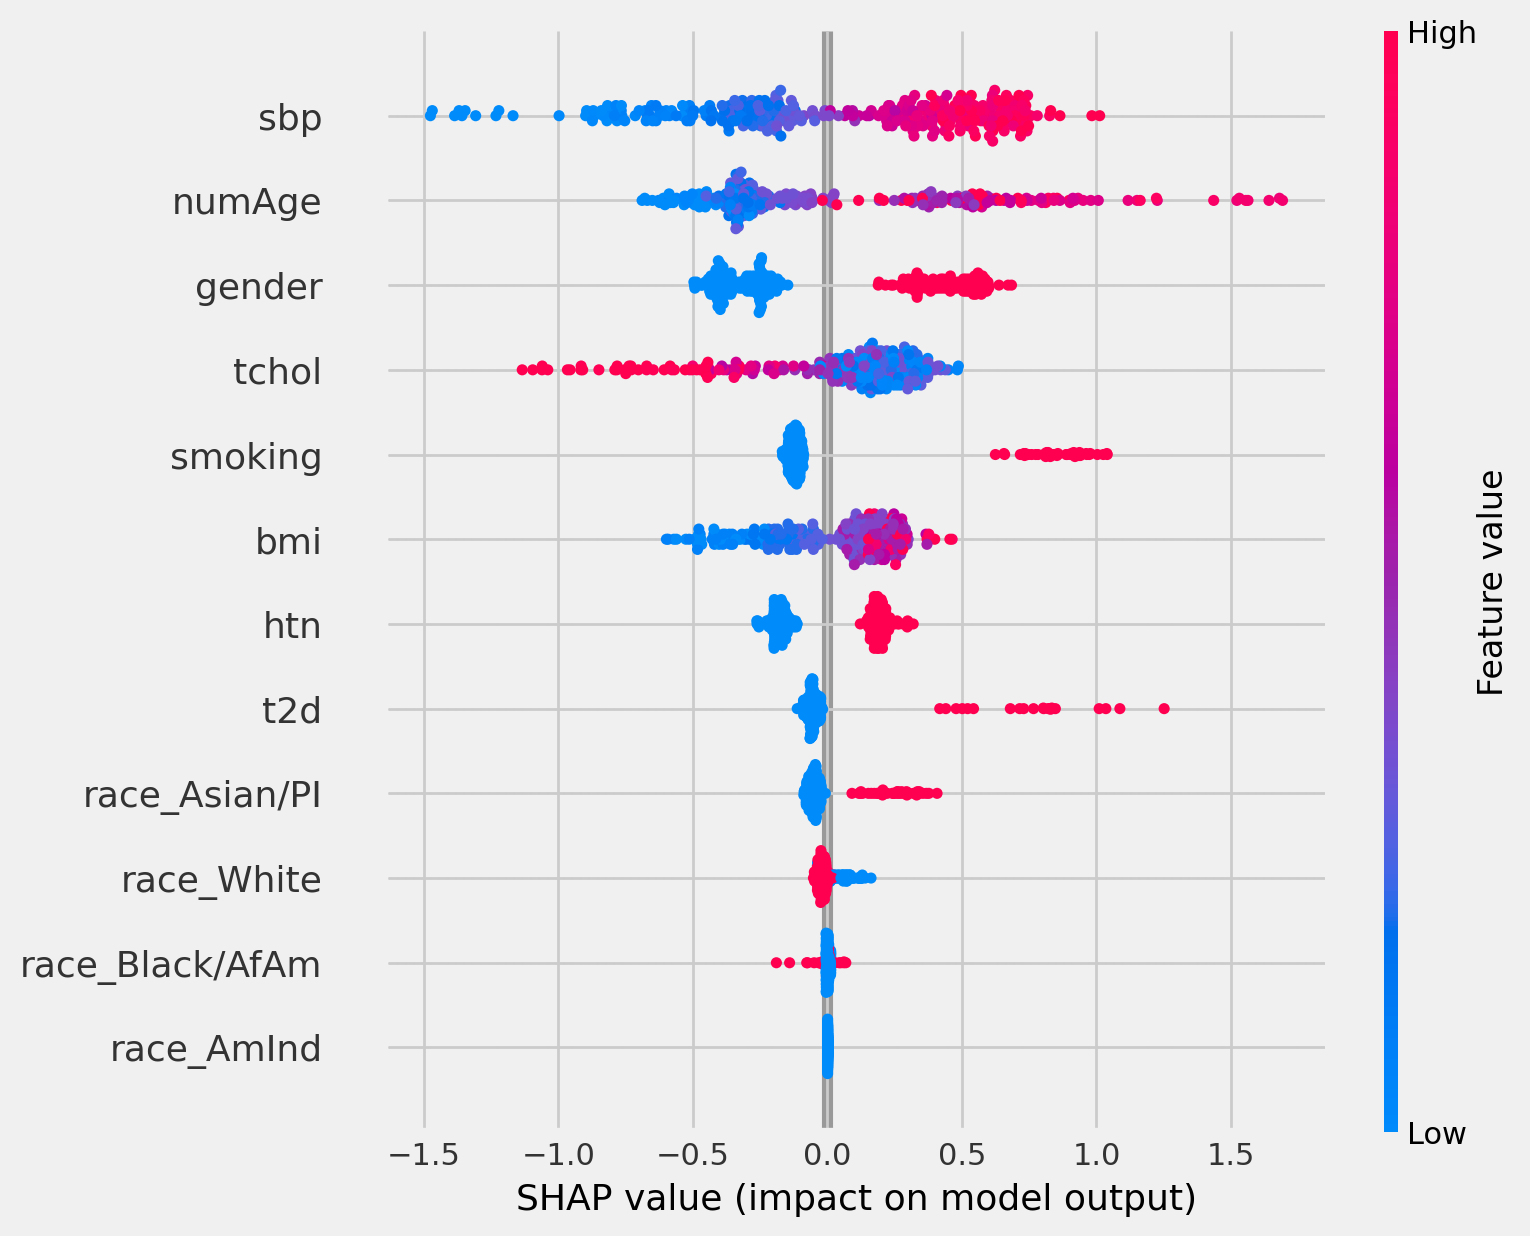

In [72]:
# Criando um gráfico de dispersão dos valores SHAP
# Este plot mostra como cada variável impacta a predição e como essa influência 
# varia de acordo com o valor da variável (efeito não linear)
shap.summary_plot(shap_values_test, X_test)

In [73]:
# Explicando uma predição individual usando SHAP
# Configurando o explainer para o modelo CatBoost
explainer = shap.TreeExplainer(catboost_otimizado)
shap_values = explainer.shap_values(X_test)

# Selecionando um paciente específico (índice 0) para análise detalhada
i = 0
# Exibindo informações sobre o paciente selecionado
print('Desfecho do paciente:', y_test[i])
print('Predição:', y_pred_catboost[i])

# Visualizando graficamente como cada variável contribuiu para a predição deste paciente específico
# Valores positivos empurram a predição para classificação positiva, negativos para negativa
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])

Desfecho do paciente: 0
Predição: 1


## Análise dos Valores de Shapley

**Importância Global das Variáveis (Gráfico de Barras):**
O gráfico revela uma hierarquia clara da influência das variáveis no modelo CatBoost. A pressão arterial sistólica (sbp) é o preditor mais poderoso, seguida pela idade (numAge) e gênero. Notavelmente, as variáveis identificadas pelo Boruta (`numAge`, `sbp`, `tchol`, `htn`) estão entre as sete principais, confirmando sua relevância. As variáveis relacionadas à raça apresentam impacto mínimo, justificando sua eliminação pelo Boruta. Esta distribuição alinha-se com o conhecimento médico estabelecido sobre fatores de risco cardiovascular.

**Relação entre Valores e Impacto (Gráfico de Dispersão):**
O gráfico SHAP de resumo mostra como o valor de cada variável afeta seu impacto na predição. Padrões importantes incluem:
- Pressão arterial (sbp): Valores elevados (pontos vermelhos) contribuem positivamente para o risco
- Idade (numAge): Efeito quase linear, com idade avançada aumentando substancialmente o risco
- Colesterol (tchol): Curiosamente, valores baixos aumentam o risco, contrariando o conhecimento tradicional
- Tabagismo (smoking) e diabetes (t2d): Quando presentes (pontos vermelhos à direita), sempre elevam o risco
- Hipertensão (htn): Efeito bimodal distinto, reforçando seu papel como marcador de risco

**Explicação para Caso Individual:**
A análise SHAP do paciente 0 (classificado erroneamente como positivo) mostra que sua idade avançada (numAge=2.137), pressão arterial elevada (sbp=0.690) e gênero masculino foram os principais fatores que empurraram a predição para um resultado positivo, superando o efeito protetor de seu baixo colesterol (tchol=-0.923). Este é um exemplo ilustrativo da capacidade do SHAP em decompor cada predição individual, possibilitando interpretações clinicamente relevantes e identificação de razões para possíveis erros do modelo.

**Sobre o SHAP e o modelo CatBoost:**
A análise SHAP proporciona insights valiosos sobre a "caixa preta" do modelo CatBoost, revelando que ele aprendeu padrões biologicamente plausíveis dos dados. A forte influência de fatores de risco cardiovascular clássicos (pressão, idade, gênero) valida a abordagem do modelo. Esta interpretabilidade é crucial para aplicações clínicas, permitindo que profissionais de saúde compreendam e confiem nas predições geradas pelo algoritmo. Além disso, as análises corroboram a seleção de variáveis realizada pelo Boruta, demonstrando a eficácia da redução de dimensionalidade.

O SHAP (SHapley Additive exPlanations) é implementado principalmente para modelos baseados em árvores de decisão (como Random Forest, XGBoost, CatBoost) porque estes possuem estrutura que facilita o cálculo eficiente dos valores de Shapley, particularmente com otimizações como o TreeSHAP.

Para o TabPFN, não aplicamos o SHAP por algumas razões:

1. **Arquitetura incompatível**: O TabPFN é baseado em transformers e redes neurais pré-treinadas, não em árvores de decisão. A implementação atual do TreeSHAP não é diretamente aplicável a esses modelos.

2. **Complexidade computacional**: Calcular os valores exatos de Shapley para redes neurais é computacionalmente muito intensivo, pois requer avaliar todas as possíveis combinações de features.

3. **Model-agnostic SHAP**: Embora existam métodos model-agnostic de SHAP que poderiam ser aplicados ao TabPFN, eles são significativamente mais lentos e menos precisos que o TreeSHAP.

4. **Natureza black-box**: O TabPFN, como um modelo baseado em transformers com parâmetros pré-treinados, é inerentemente mais "black-box" que modelos baseados em árvores.

É possível aplicar técnicas alternativas de interpretabilidade ao TabPFN, como análise de permutação de features ou LIME (Local Interpretable Model-agnostic Explanations), mas estas não foram implementadas no projeto atual.

Optamos por realizar o SHAP no CatBoost por ser um modelo de alto desempenho com suporte nativo e eficiente para a interpretação via SHAP, proporcionando insights valiosos sobre a importância das variáveis e seu impacto nas predições individuais.

---

## 11. Salvando e carregando o modelo - Ações exemplo para utilização de modelos desenvolvidos e otimizados

Após desenvolver e validar nosso modelo de predição de risco cardiovascular, é importante salvar o modelo treinado para uso futuro. Esta prática permite:

- Implantar o modelo em ambientes de produção
- Reutilizar o modelo sem necessidade de retreinamento
- Compartilhar o modelo com outros pesquisadores ou equipes
- Integrar o modelo em aplicações clínicas de suporte à decisão

Usaremos a biblioteca `joblib` para serializar e persistir o modelo CatBoost otimizado.


In [74]:
def save_model(model, path):
    """Função para salvar o modelo localmente.
    Args:
        model: Modelo para salvar
        path (str): caminho para salvar o modelo
    """
    if os.path.dirname(path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        joblib.dump(model, f)

In [75]:
# Salvando o modelo CatBoost otimizado
# Criamos um diretório 'models' para armazenar o modelo serializado
save_model(catboost_otimizado, 'models/catboost_otimizado.pkl')

## Carregando um modelo desenvolvido previamente

Para utilizar um modelo previamente treinado e salvo, precisamos implementar uma função de carregamento. Isso é particularmente útil em cenários práticos onde:

- Modelos são treinados em ambientes de alta performance e depois implantados em sistemas de produção
- Equipes diferentes são responsáveis pelo desenvolvimento e pela aplicação dos modelos
- Desejamos aplicar o mesmo modelo a novos dados sem repetir o processo de treinamento


In [76]:
def read_model(path):
    """Função para ler um modelo salvo
    Args:
        path (str): caminho do modelo salvo
    Returns:
        file: modelo carregado
    """
    with open(path, "rb") as f:
        file = joblib.load(f)

    return file

In [77]:
# Carregando o modelo salvo
# Em uma aplicação real, este seria o ponto de entrada para uso do modelo treinado
modelo_carregado = read_model('models/catboost_otimizado.pkl')

In [78]:
# Verificando os hiperparâmetros do modelo carregado
# Isto confirma que o modelo foi carregado corretamente com todas as suas configurações
modelo_carregado.get_params()

{'iterations': 1000,
 'learning_rate': 0.01,
 'depth': 4,
 'l2_leaf_reg': 10,
 'border_count': 50,
 'random_seed': 42,
 'silent': True,
 'eval_metric': 'Logloss'}

In [79]:
# Validando o modelo carregado no conjunto de teste
# Em aplicações reais, após as etapas de pré-processamento nos dados novos,
# as predições seriam feitas com o modelo carregado
resultado = modelo_carregado.score(X_test, y_test)
resultado

0.7466666666666667

# Machine Learning para Predições em Saúde: Conclusão do Projeto

## Resumo do Projeto

Este projeto demonstrou a aplicação de técnicas avançadas de machine learning para predição de risco cardiovascular utilizando dados de saúde. Comparamos cinco algoritmos distintos, incluindo o recente TabPFN (Tabular Prior-Data Fitted Networks), uma abordagem inovadora baseada em transformers para dados tabulares.

## Etapas Realizadas

1. **Configuração do Ambiente**: Instalamos bibliotecas especializadas para análise de dados e machine learning, incluindo ferramentas para visualização e implementação de modelos preditivos.

2. **Exploração de Dados**: Trabalhamos com um dataset contendo informações de saúde de 425.195 pacientes, filtrando para pacientes com idade superior a 55 anos (125.335 registros) por representarem maior risco cardiovascular.

3. **Pré-processamento**: Implementamos transformações como one-hot encoding para variáveis categóricas, label encoding para variáveis binárias, e padronização para variáveis numéricas, preparando os dados para modelagem.

4. **Desenvolvimento e Otimização de Modelos**: Treinamos e otimizamos cinco algoritmos:
   - Random Forest
   - XGBoost
   - LightGBM
   - CatBoost
   - TabPFN

5. **Avaliação Comparativa**: O TabPFN apresentou o melhor desempenho geral com acurácia de 76.67%, precisão de 62.50%, recall de 55.56% e AUC de 0.7884, destacando-se pela capacidade de equilibrar precisão e recall sem necessidade de otimização extensiva.

6. **Seleção de Variáveis**: O algoritmo Boruta identificou apenas quatro variáveis como verdadeiramente relevantes: idade, colesterol total, pressão arterial sistólica e hipertensão, reduzindo a dimensionalidade do modelo em 67%.

7. **Interpretabilidade**: Aplicamos análise SHAP ao modelo CatBoost, revelando que pressão arterial sistólica, idade e gênero são os principais fatores influenciando o risco cardiovascular, alinhados com o conhecimento médico estabelecido.

8. **Persistência do Modelo**: Implementamos funcionalidades para salvar e carregar modelos, permitindo sua integração em sistemas de produção.

## Relevância do TabPFN

O TabPFN destacou-se como uma alternativa promissora aos métodos tradicionais por várias razões:

1. **Desempenho Superior**: Obteve os melhores resultados em acurácia e AUC, superando algoritmos estabelecidos como CatBoost e XGBoost.

2. **Simplicidade de Implementação**: Não exigiu otimização de hiperparâmetros, mantendo código minimalista.

3. **Equilíbrio Precision-Recall**: Conseguiu bom balanço entre precisão e recall, crucial para aplicações clínicas.

4. **Adaptabilidade a Datasets Pequenos**: Demonstrou excepcional capacidade de generalização mesmo com amostra relativamente pequena.

5. **Transferência de Conhecimento**: Sua arquitetura pré-treinada em múltiplas tarefas tabulares permite aplicar conhecimento transferido a novos problemas.

## Implicações para Predições em Saúde

Este projeto ilustra como modelos de machine learning podem auxiliar na identificação de pacientes com maior risco cardiovascular, potencialmente melhorando:

- Triagem de pacientes para intervenções preventivas
- Alocação eficiente de recursos de saúde
- Personalização de planos de tratamento
- Apoio à decisão clínica com modelos interpretáveis

A abordagem metodológica seguida neste projeto serve como template para desenvolvimento de soluções de IA em outros contextos de saúde, equilibrando desempenho preditivo, interpretabilidade e aplicabilidade clínica. Espero que tenha gostado! Fique à vontade para entrar em contato comigo via GitHub ou Linkedin, e conheça o trabalho do LABDAPS!